Following the workshop on 19/11/2020 this script aims to apply the EDA in long-term-workflow.ipynb to multiple sites with particular emphasis on comparing this analysis across sites

update 02/12/2020
1. Standardised deseasonalised data has been added. The motivation here is that the COUNTS data has differeing variance for each season and the high variance in the summer months made it hard to determine the behaviour of the de-seasonalied data over the winter months. 
 - Seasonal sub-series plot added
 - Multi-frequency changepoints (very interesting!)
 - Multi-frequency and univariate changepoints
 
1. Moving average segmentations updated
 - Multi-frequency changepoint
 - Multi-frequency and univariate changepoints

In [1]:
setwd("/data/notebooks/jupyterlab-workshop")
source("R/helper.R")
#source("cpt/source.R")
options(repr.plot.width = 27, repr.plot.height = 15)
#options(repr.plot.width = 13, repr.plot.height = 7)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Parsed with column specification:
cols(
  IM_SPEC = col_double(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)

Parsed with column specification:
cols(
  IM_SPEC = col_character(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)



Get the data for the analysis

In [2]:
data <- multi_site_analysis(sites = c("T08", "T09"),#, "T06"),
                            dataset = "moth", 
                            daterange = c("1950-01-01","2021-01-01"),
                            avg_missing_data = TRUE, 
                            plotPredOpt = NA)
nsites <- length(unique(data$site))

[1] "site:" "T08"  


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'year(DATETIME)' (override with `.groups` argument)



[1] "check_alldates: assuming dates are recorded same day each month"
[1] "missing dates:" "FALSE"         


Joining, by = "DATETIME"

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "month"

Joining, by = c("DATETIME", "ma2x12")

`summarise()` regrouping output by 'month' (override with `.groups` argument)

Joining, by = c("month", "site")



[1] "site:" "T09"  


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'year(DATETIME)' (override with `.groups` argument)



[1] "check_alldates: assuming dates are recorded same day each month"
[1] "missing dates:" "TRUE"          


Joining, by = "DATETIME"

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "month"

Joining, by = c("DATETIME", "ma2x12")

`summarise()` regrouping output by 'month' (override with `.groups` argument)

Joining, by = c("month", "site")

Joining, by = c("DATETIME", "counts", "yearmonth", "month", "ma2x12", "detrend_ma2x12", "decomp_seas_comp", "std_decomp_seas", "decomp_deseason", "site", "cpts", "decomp_deseason_sd", "decomp_deseason_std")



# Plot the counts

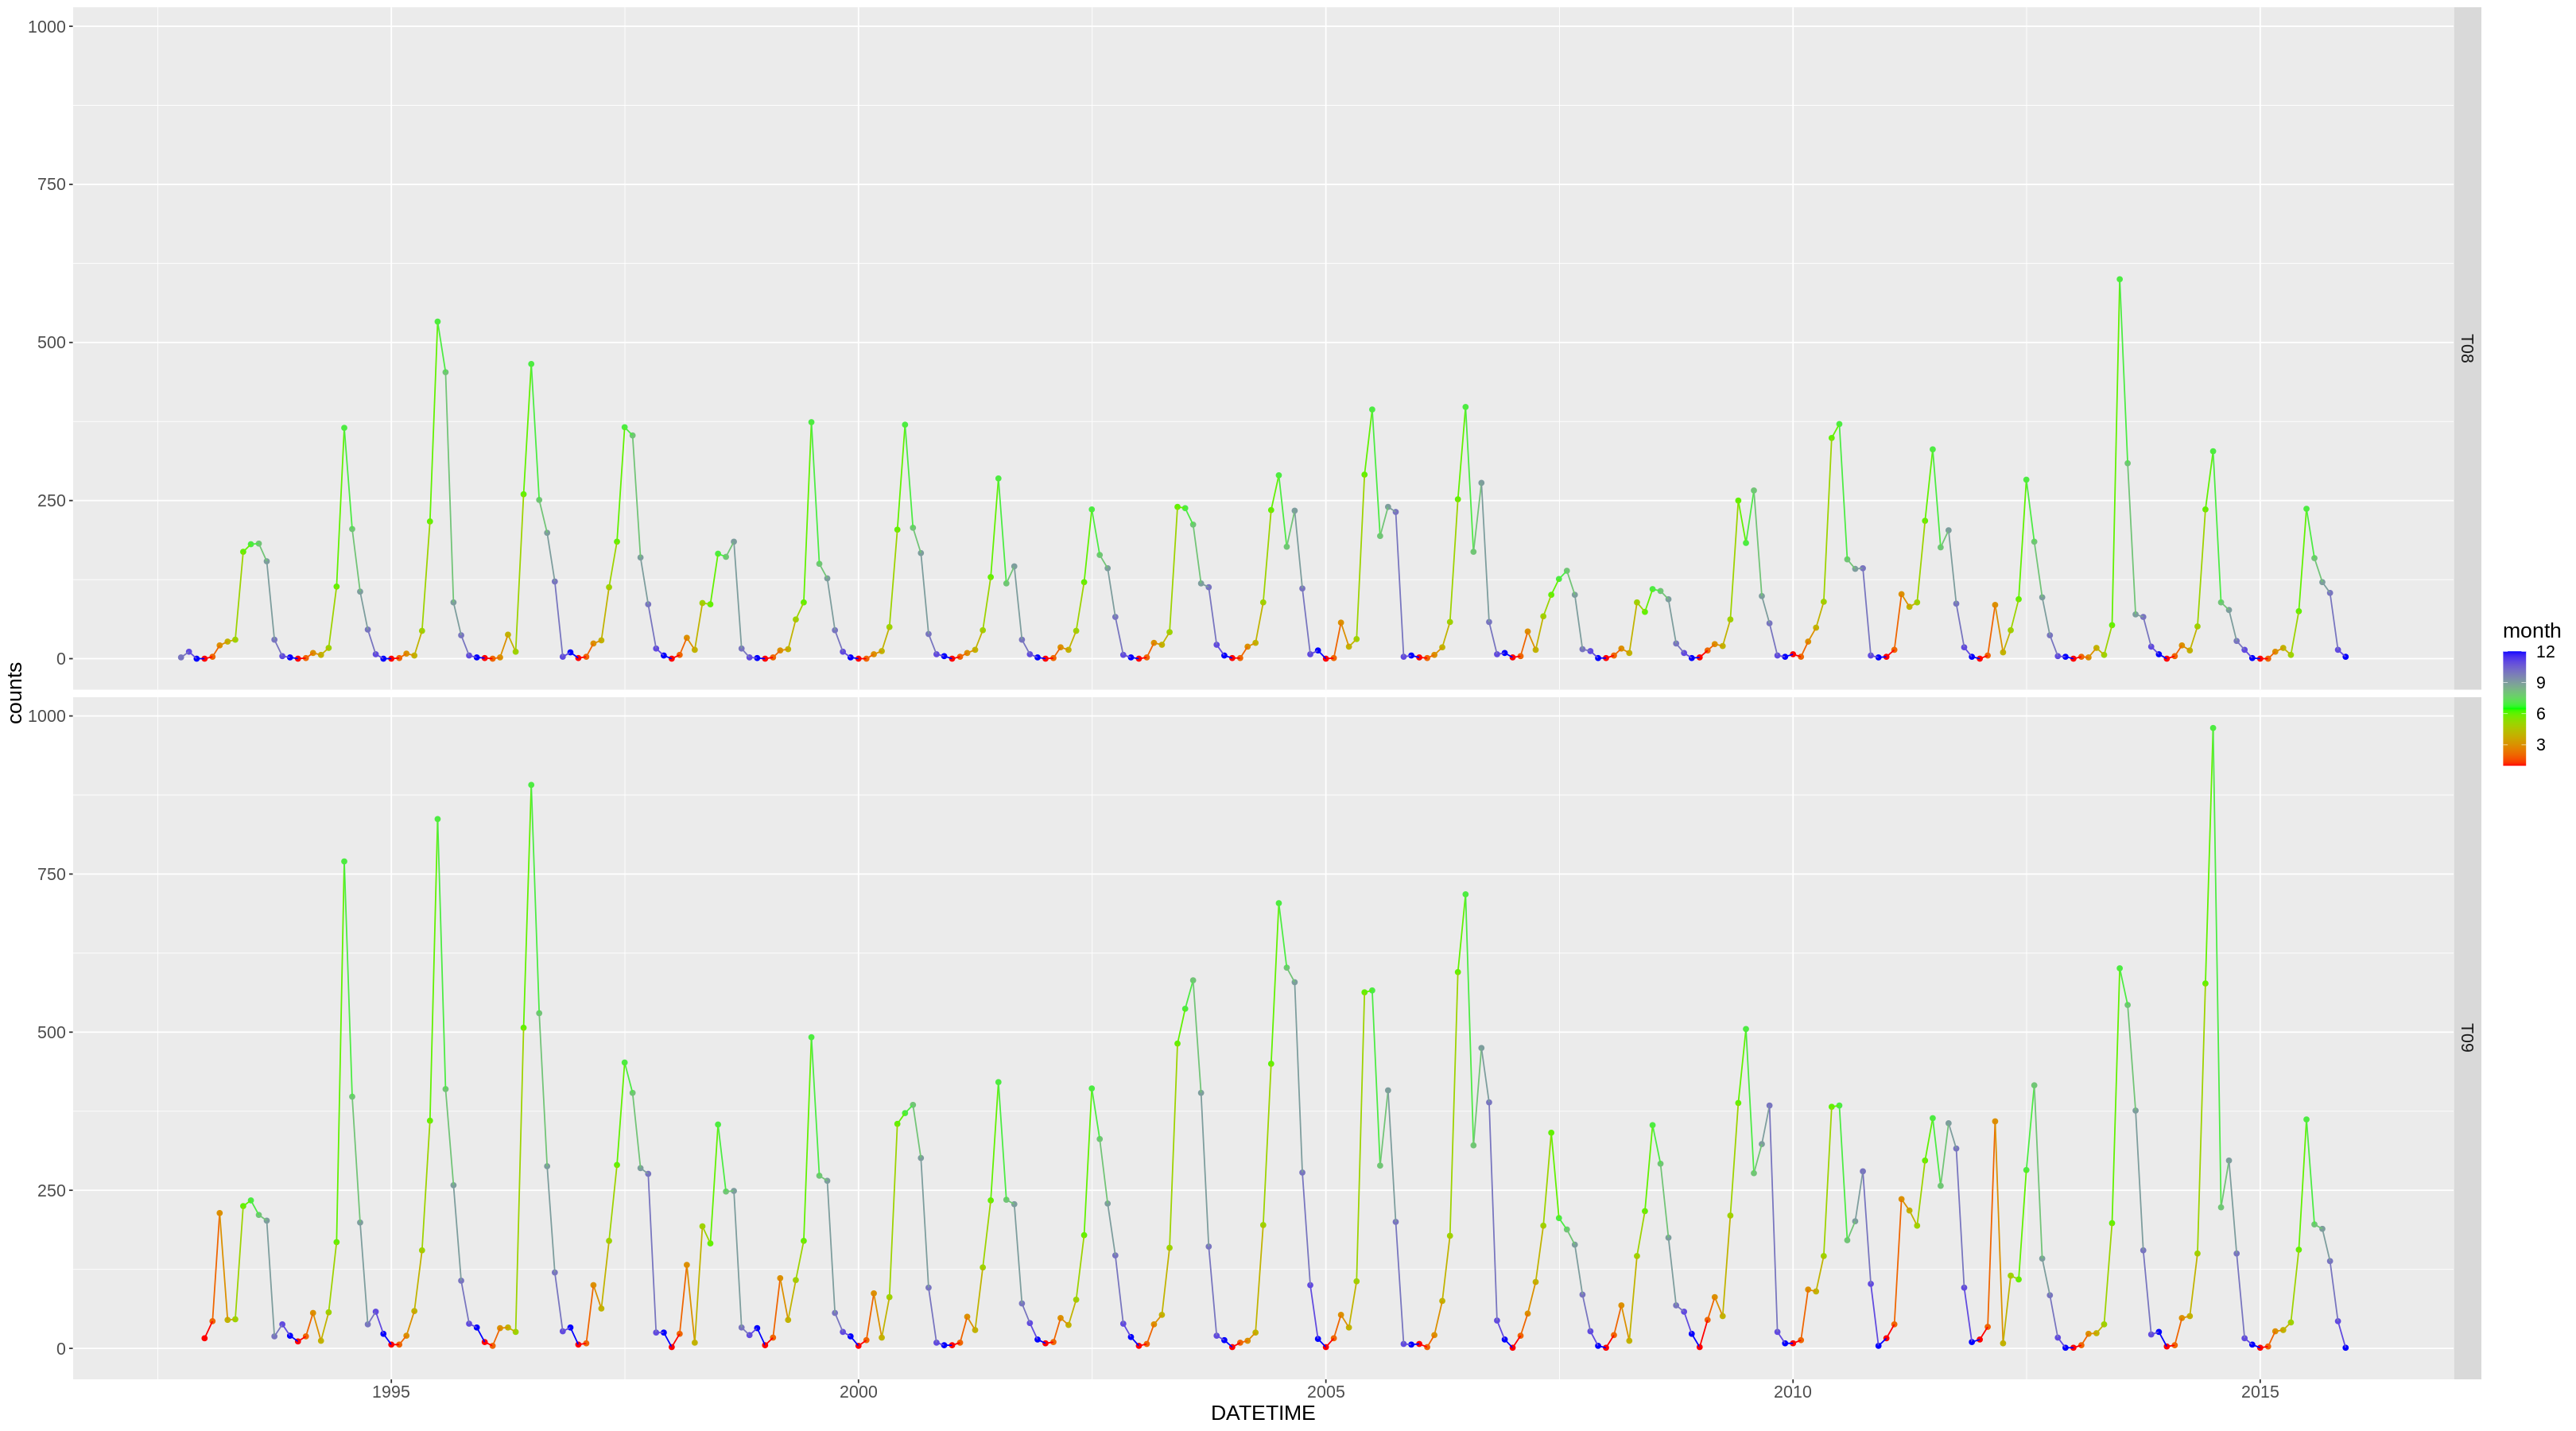

In [3]:
data %>% ggplot2::ggplot(aes(x = DATETIME, y = counts, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) +
    ggplot2::facet_grid(site ~ .) + 
    theme(text = element_text(size = 16))

# Seasonal sub-series plot
Plot the counts by month over the daterange

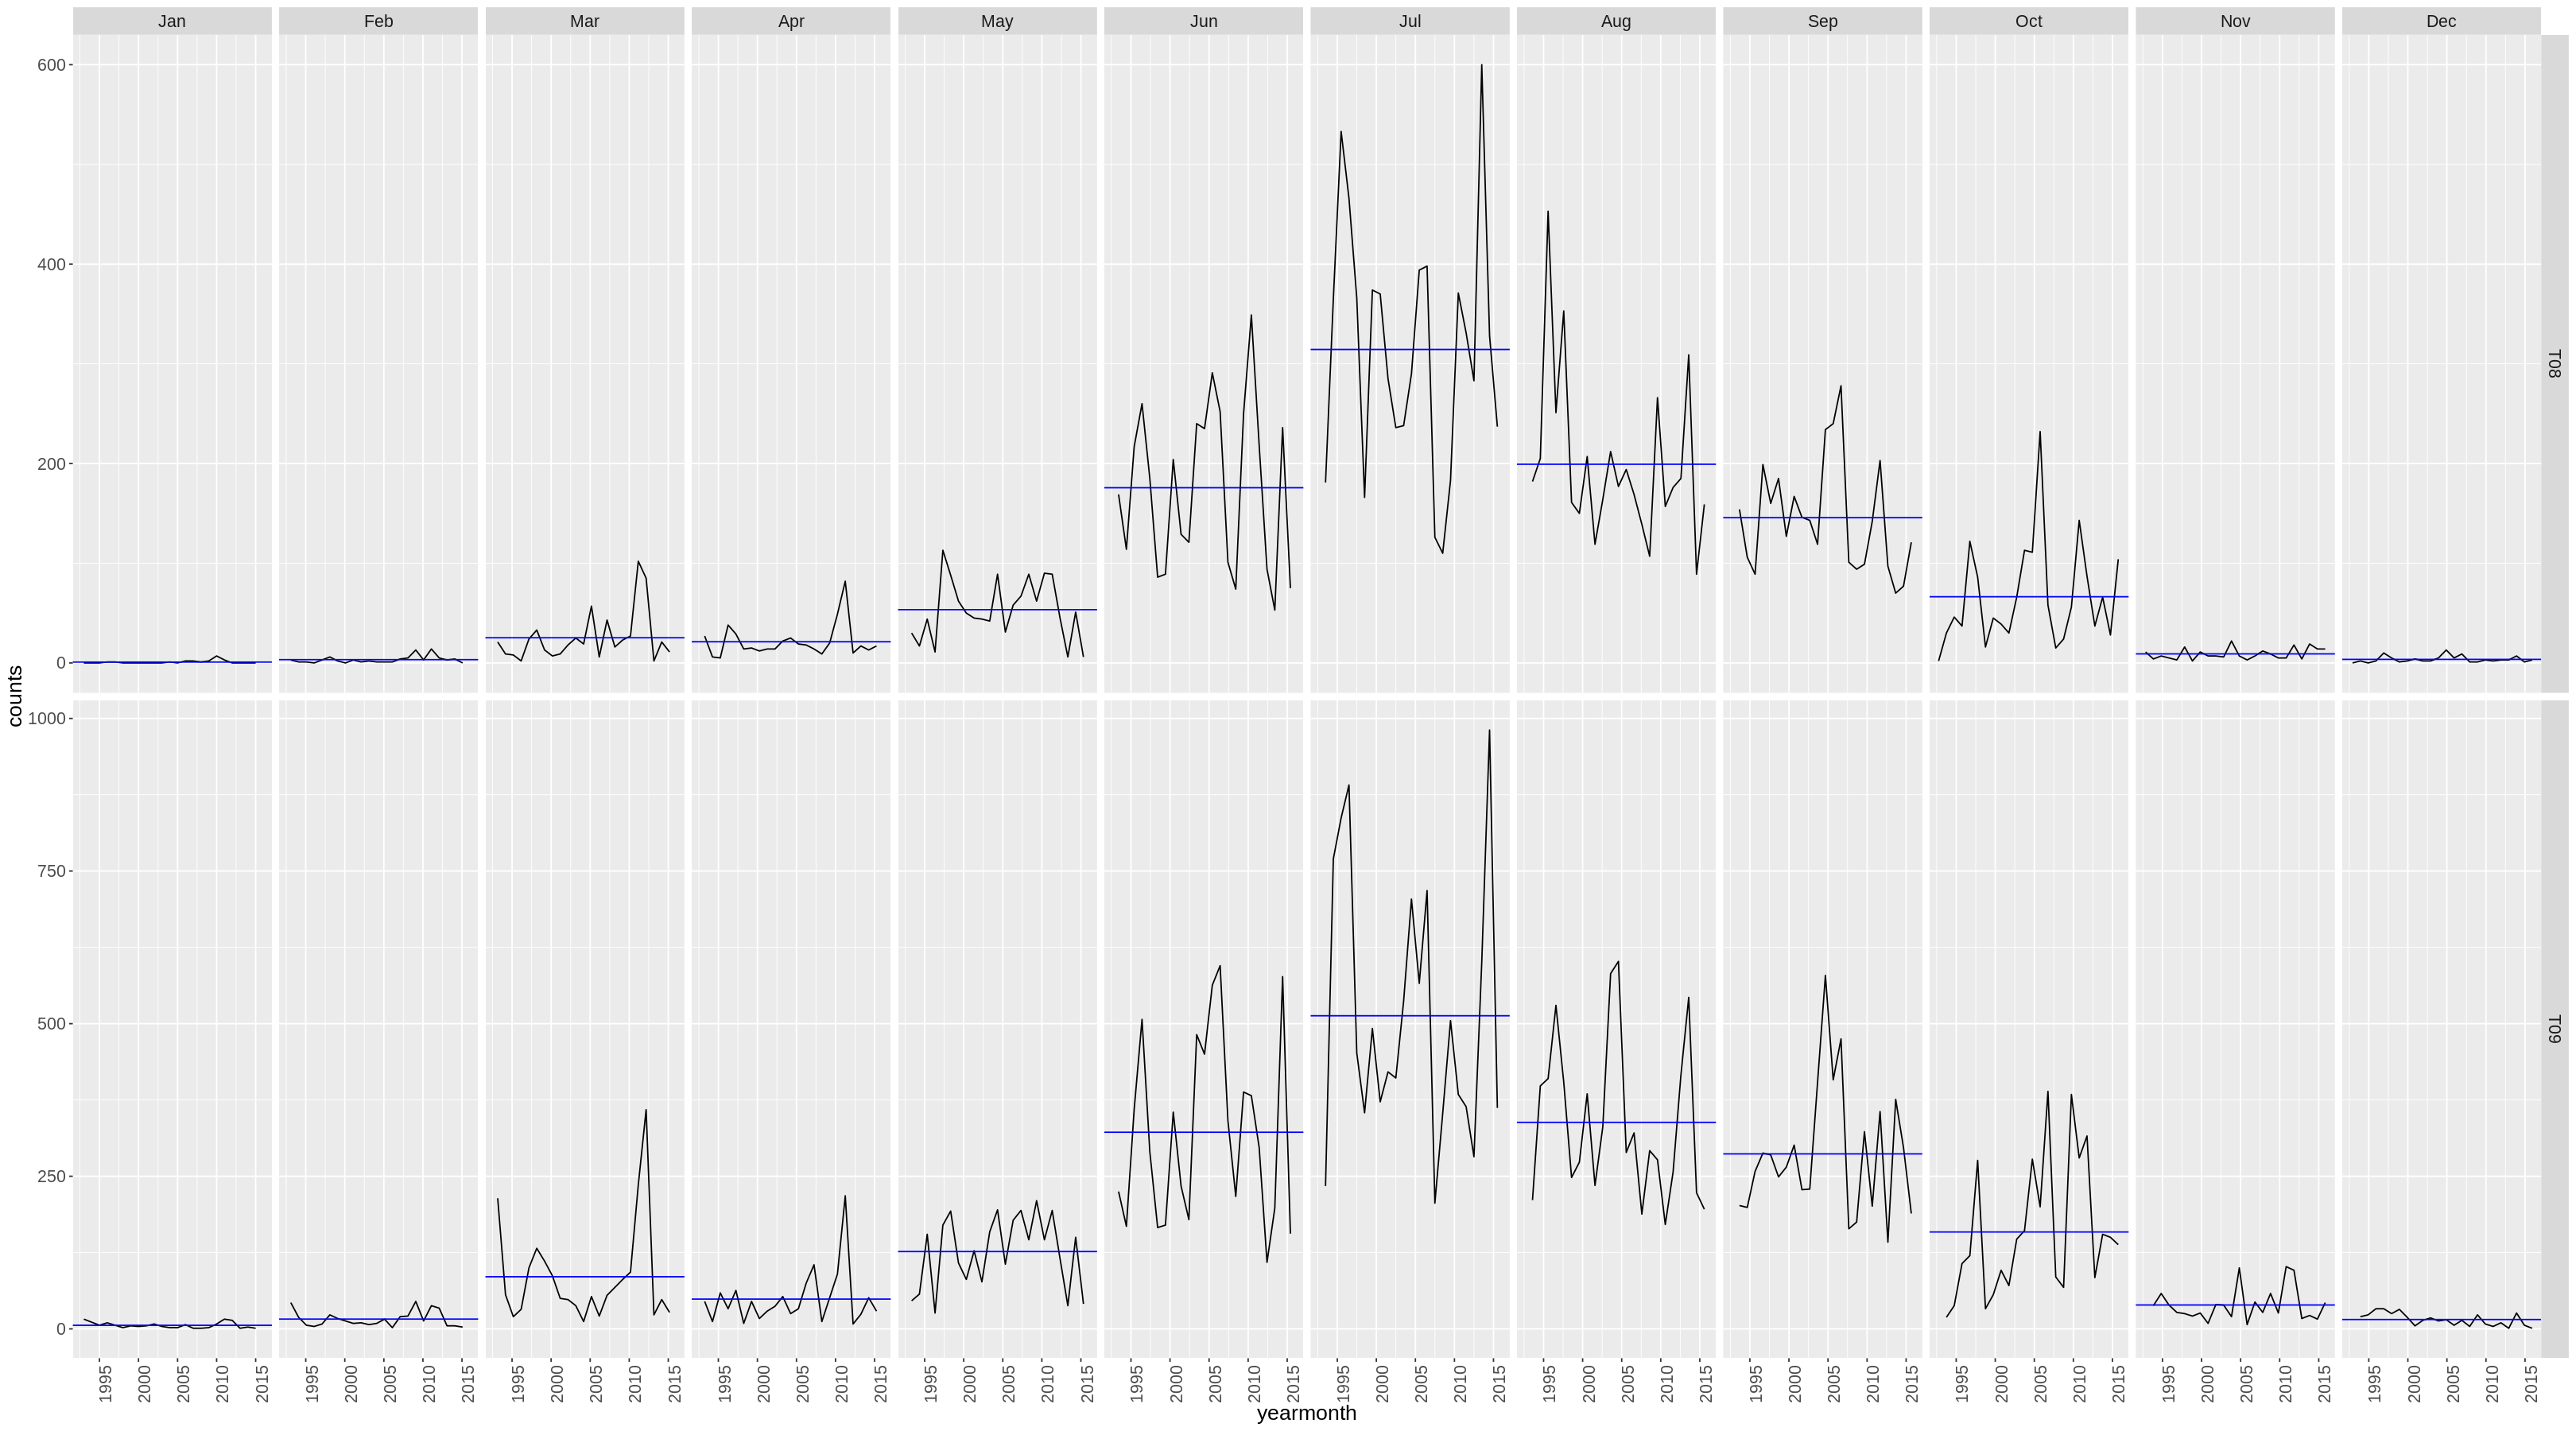

In [4]:
data %>% tsibble::as_tsibble(index=yearmonth, key=site) %>% 
    feasts::gg_subseries(y=counts) + 
    theme(text = element_text(size = 16))

# Subseries plot of decomp_deseason_std

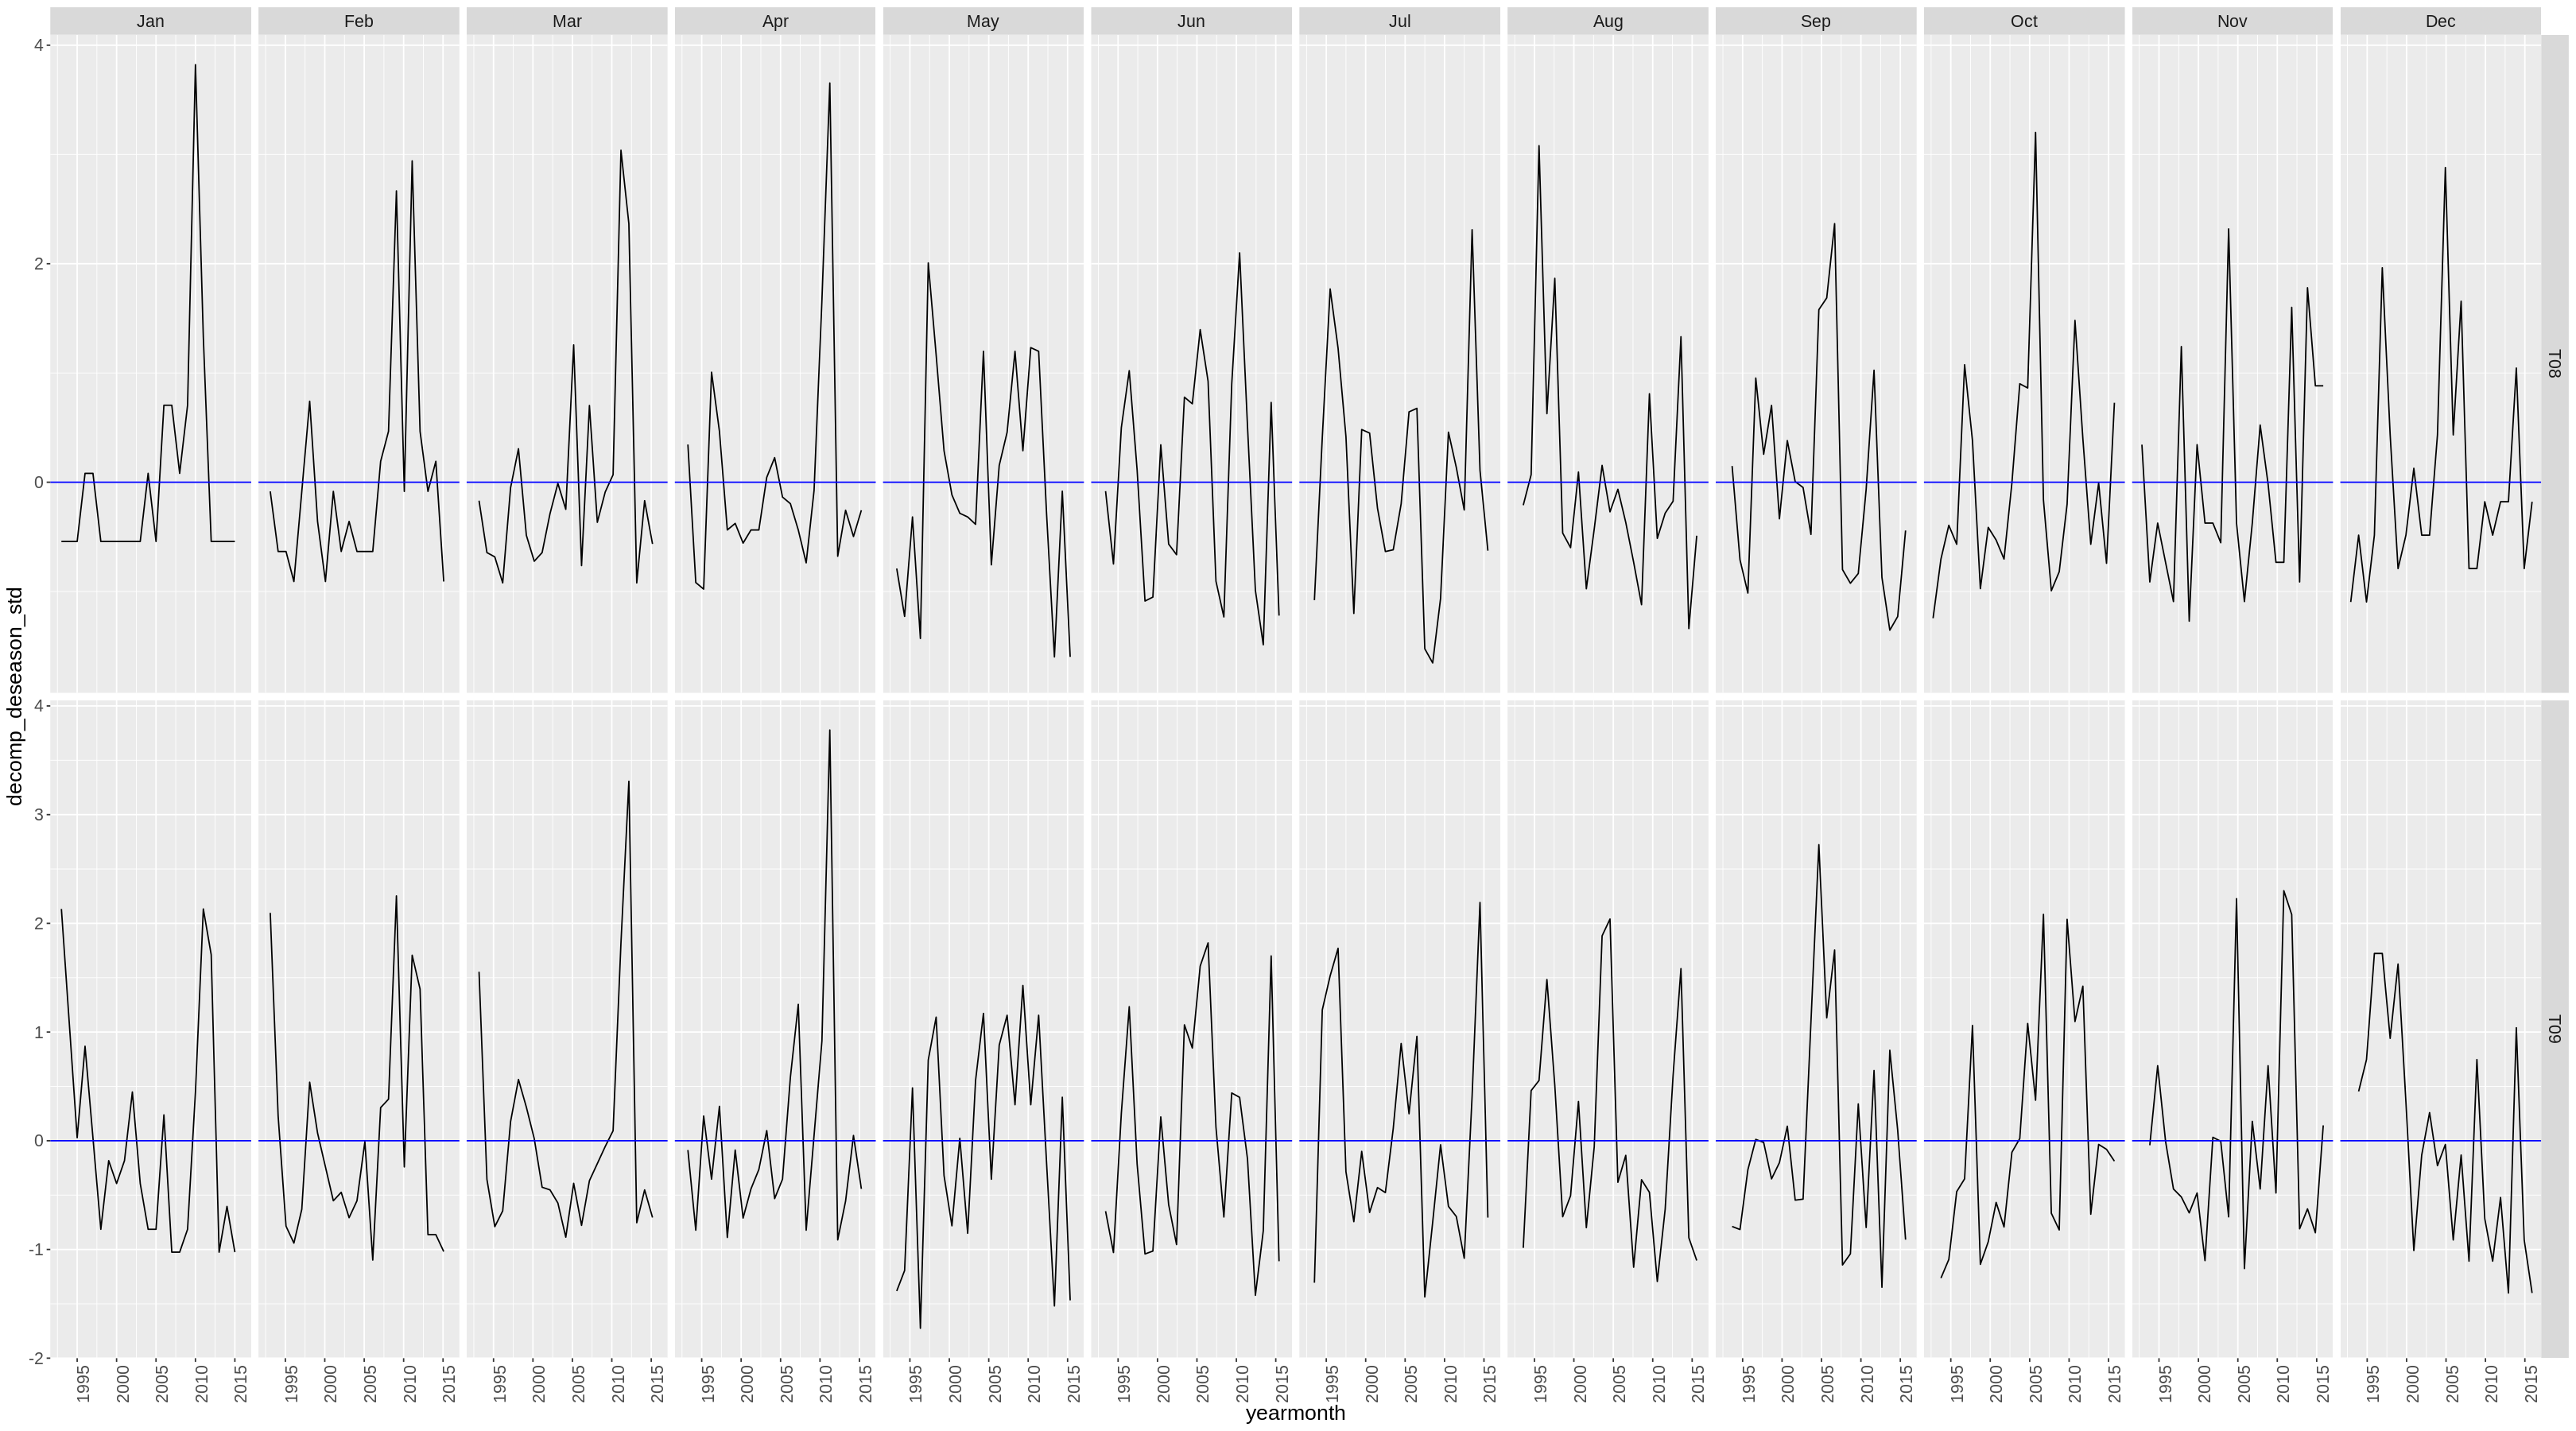

In [5]:
data %>% tsibble::as_tsibble(index=yearmonth, key=site) %>% 
    feasts::gg_subseries(y=decomp_deseason_std) + 
    theme(text = element_text(size = 16))

# Seasons over date range
Plot the counts over daterange but colour by season (month)

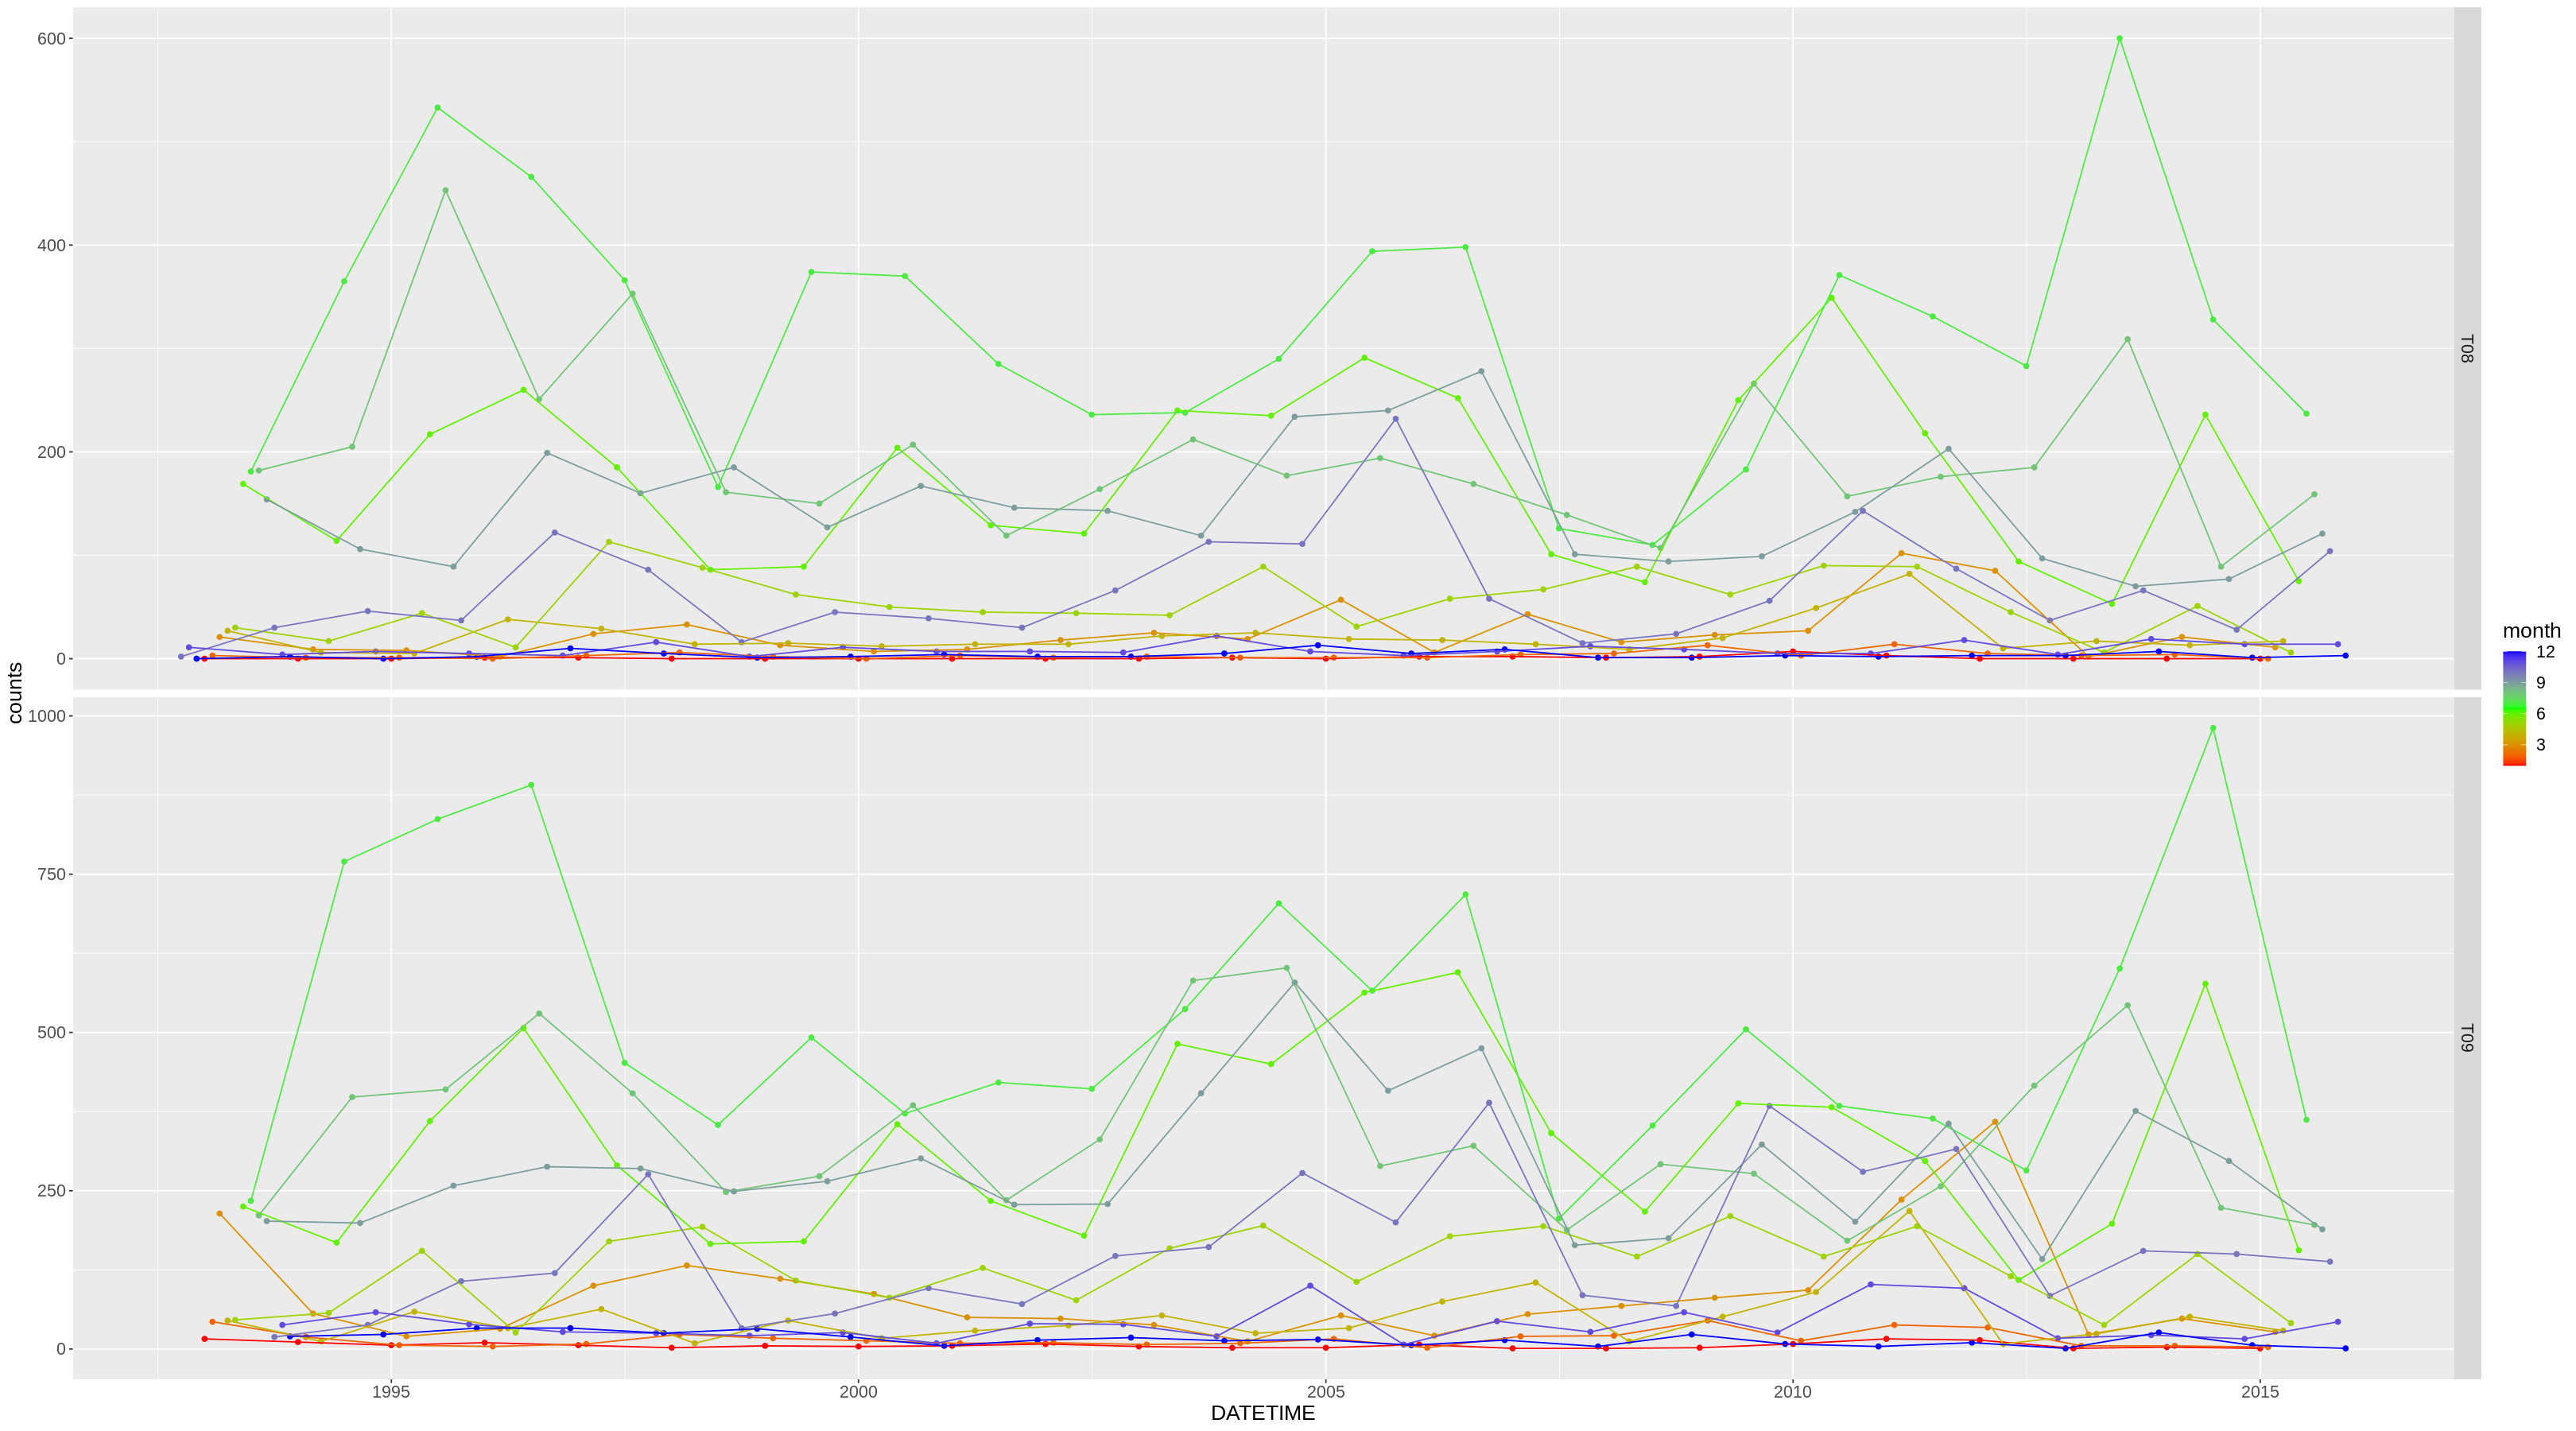

In [6]:
data %>% ggplot2::ggplot(aes(x = DATETIME, y = counts, group=month, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) +
    ggplot2::facet_grid(site ~ ., scales="free_y") + 
    theme(text = element_text(size = 16))

# Seasons over data range (deseasonalised values)
Plot the deseasonalised counts over daterange but colour by season (month)

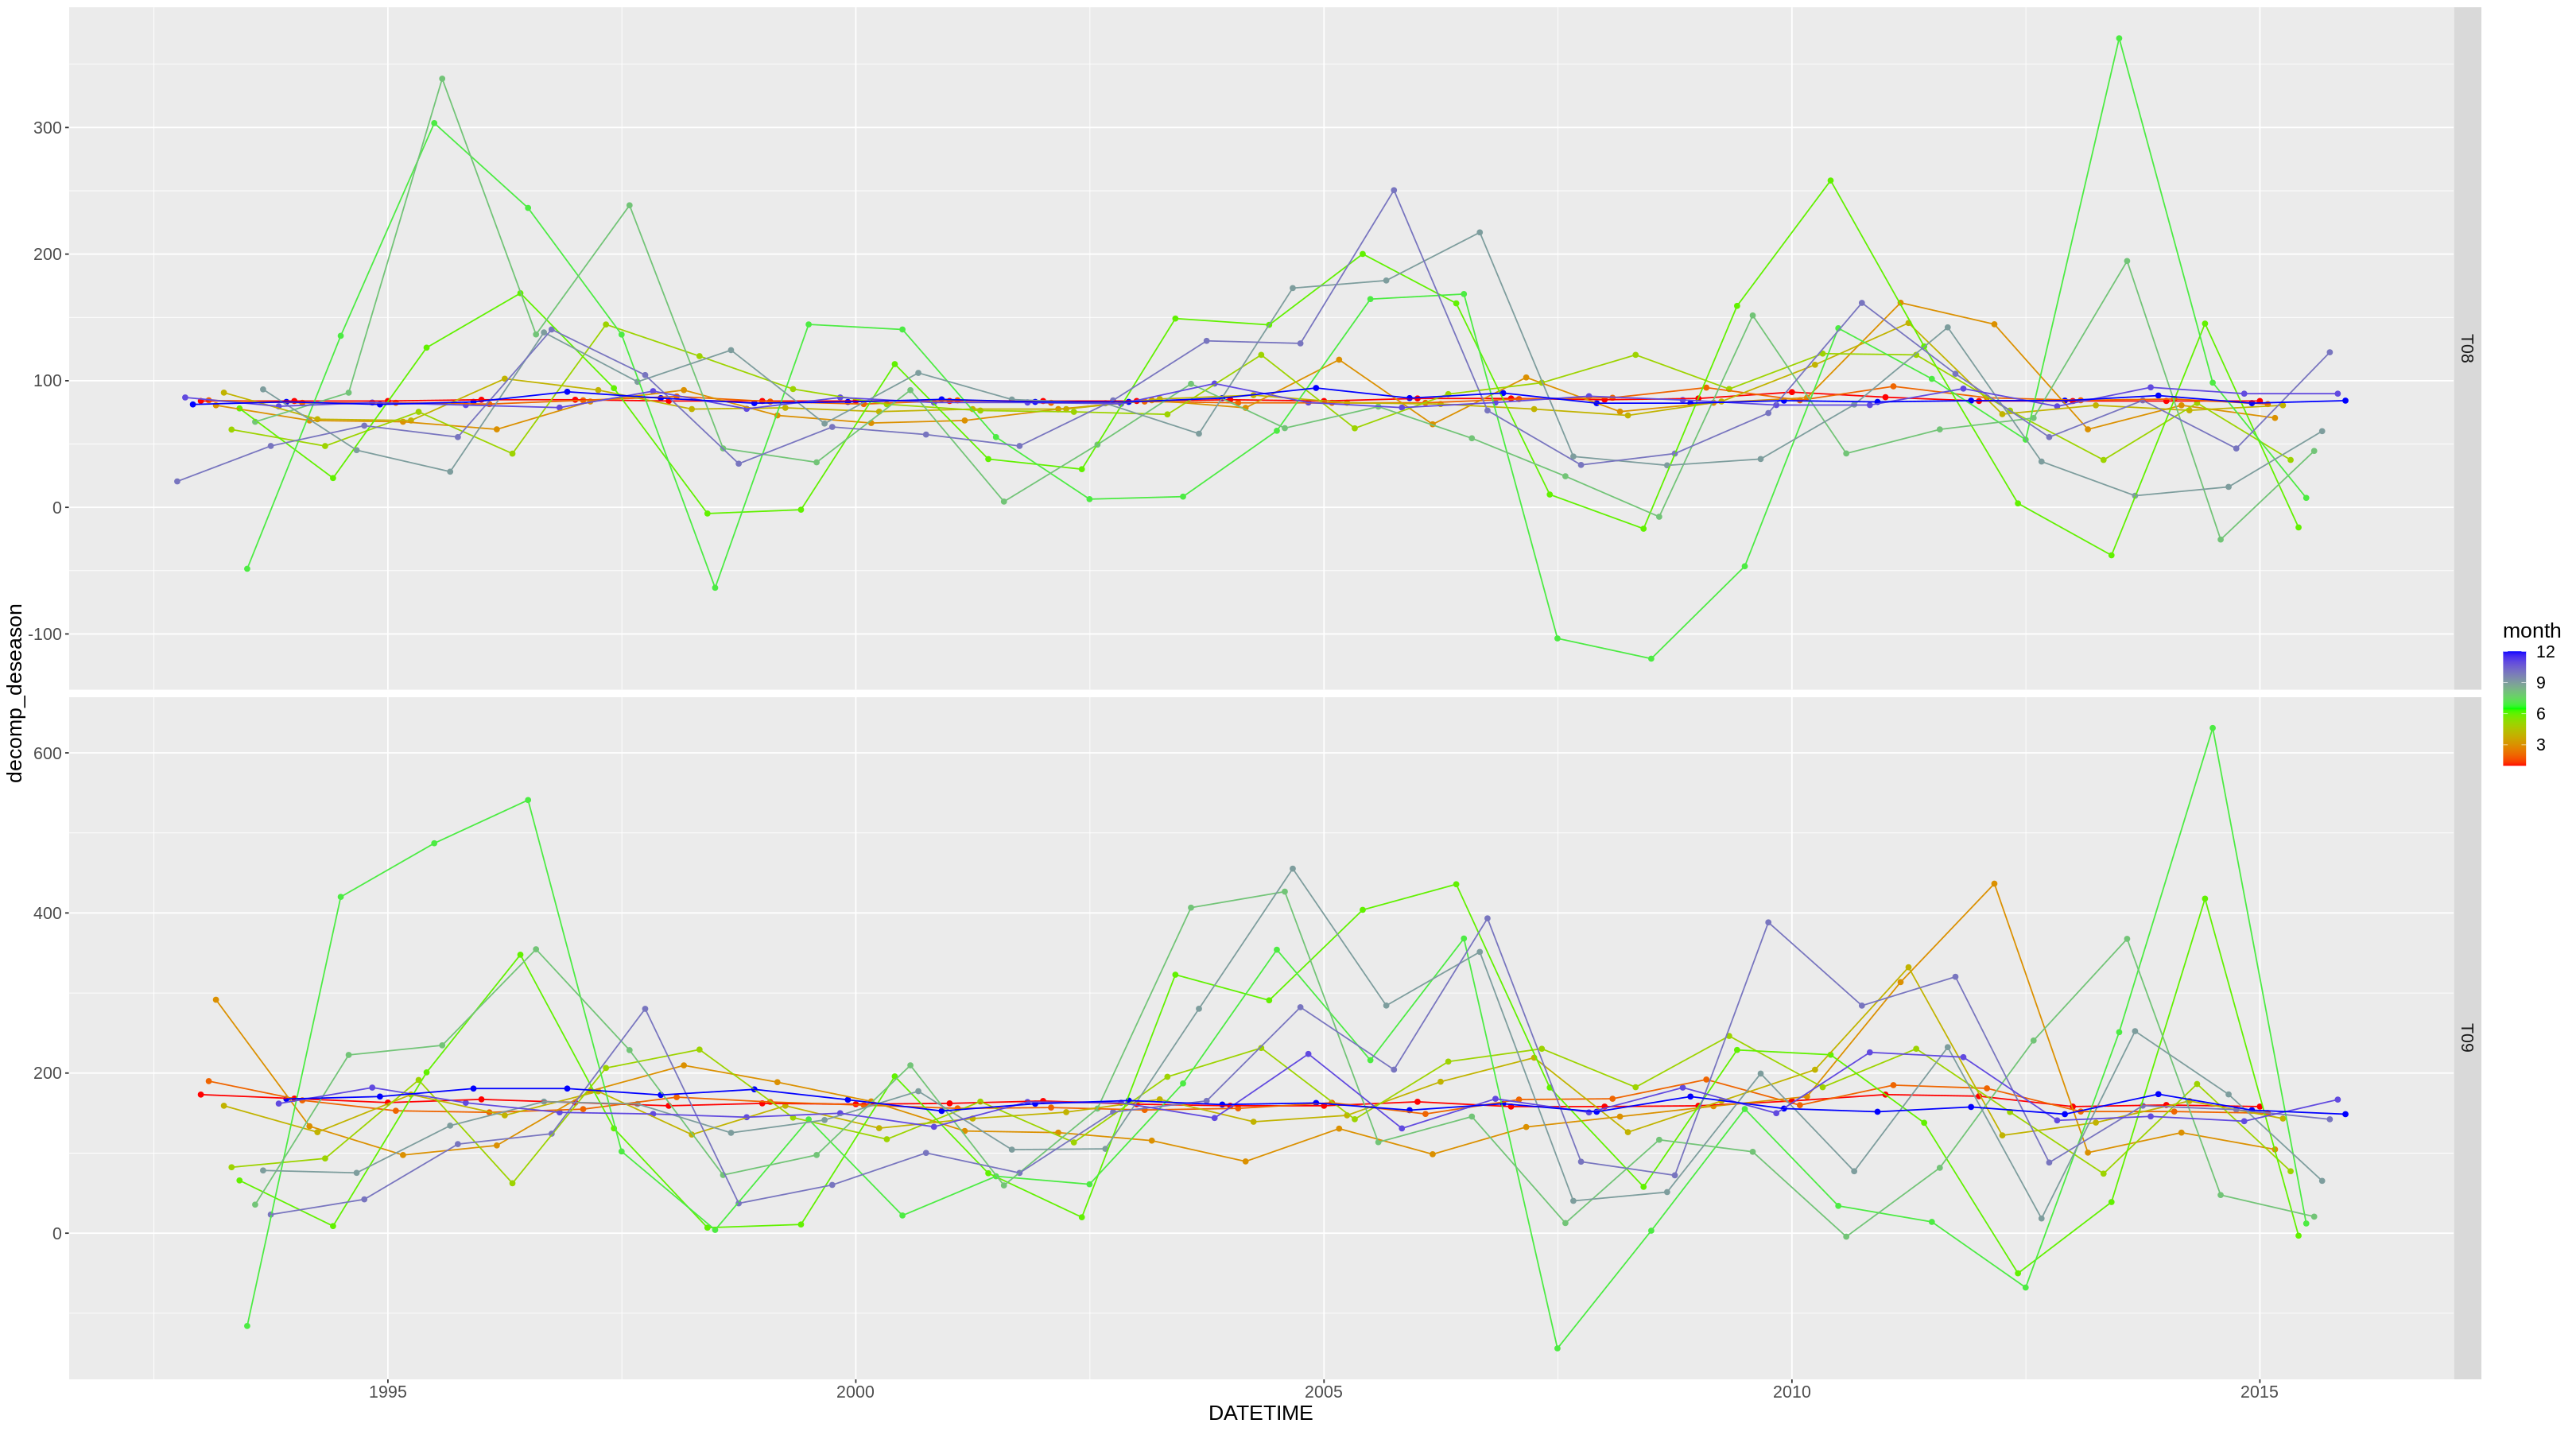

In [7]:
data %>% ggplot2::ggplot(aes(x = DATETIME, y = decomp_deseason, group=month, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) +
    ggplot2::facet_grid(site~., scales="free_y") + 
    theme(text = element_text(size = 16))

# Deseasonalised counts
Plot the deseasonalised counts 

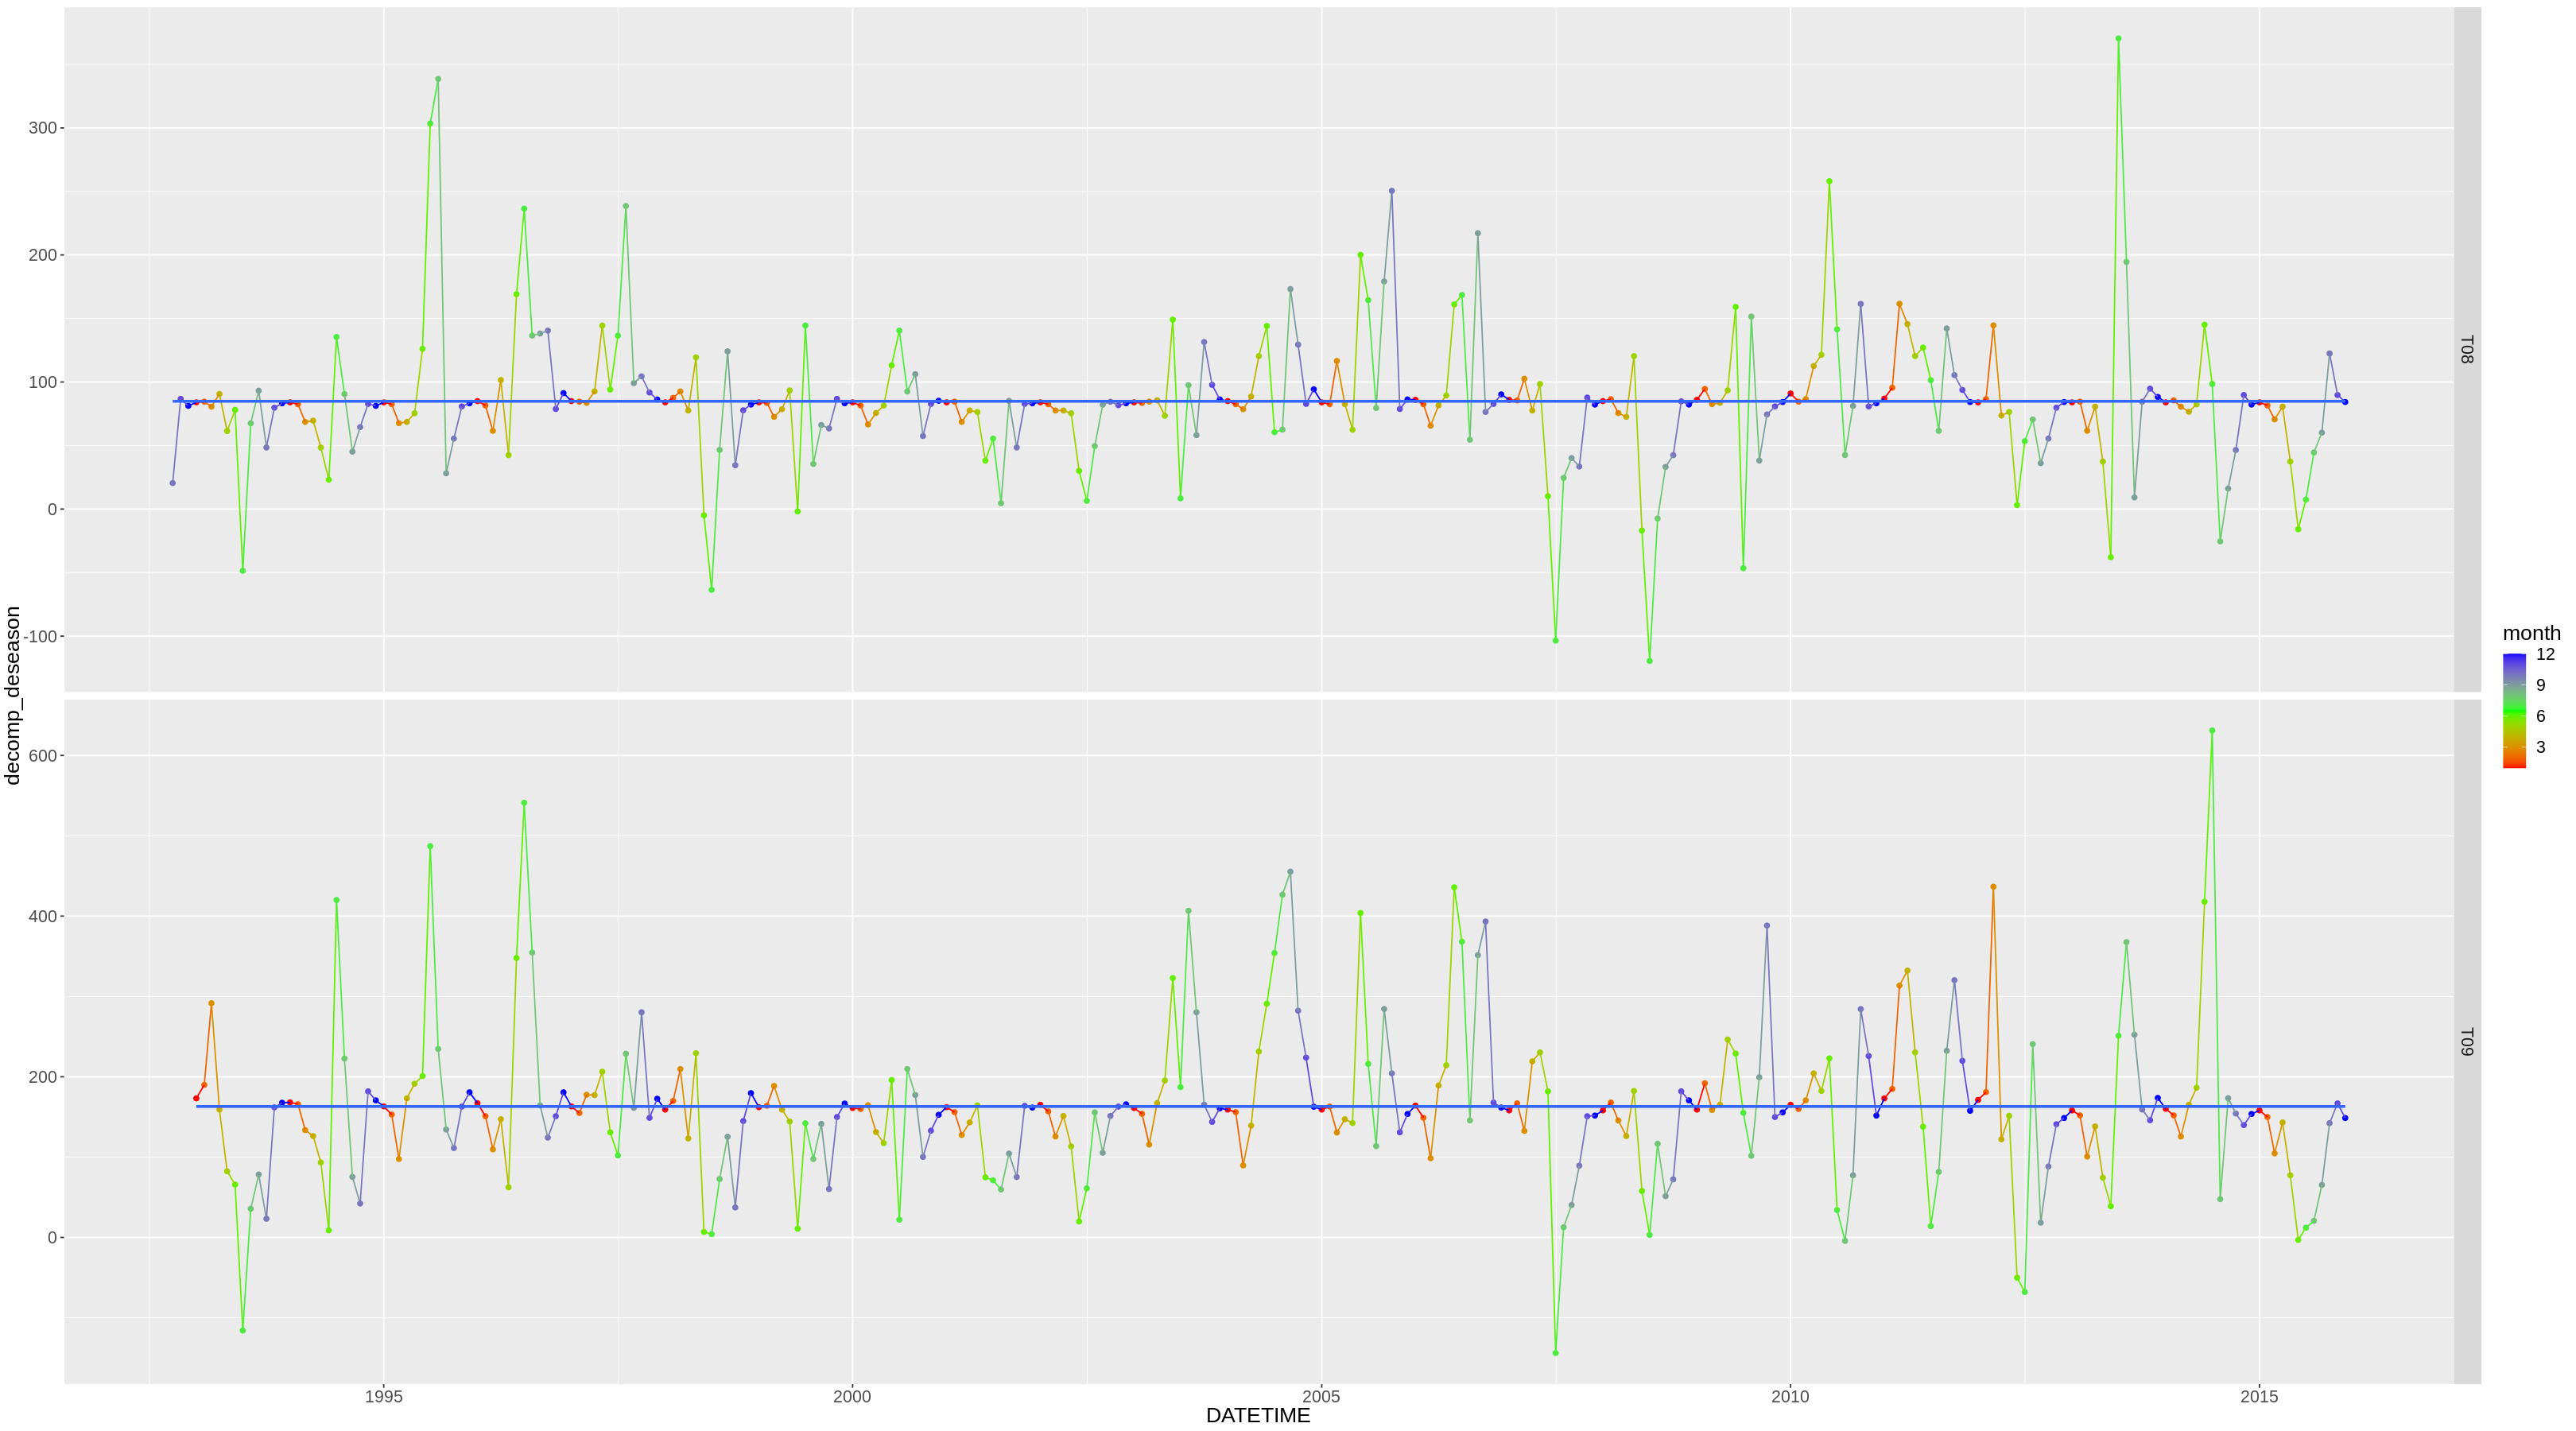

In [8]:
deseasonalised_counts <- data %>% 
    ggplot2::ggplot(aes(x = DATETIME, y = decomp_deseason, color=month)) + 
    geom_point() +
    geom_line() + 
    scale_color_gradientn(colours = rainbow(3)) +
    stat_smooth(method='lm', formula=y~1, se=F) +
    facet_grid(site ~ ., scales='free_y') + 
    theme(text = element_text(size = 16))

print( deseasonalised_counts )

# Add multi frequency changepoints (new method)

Joining, by = c("site", "cpt.type", "loc")



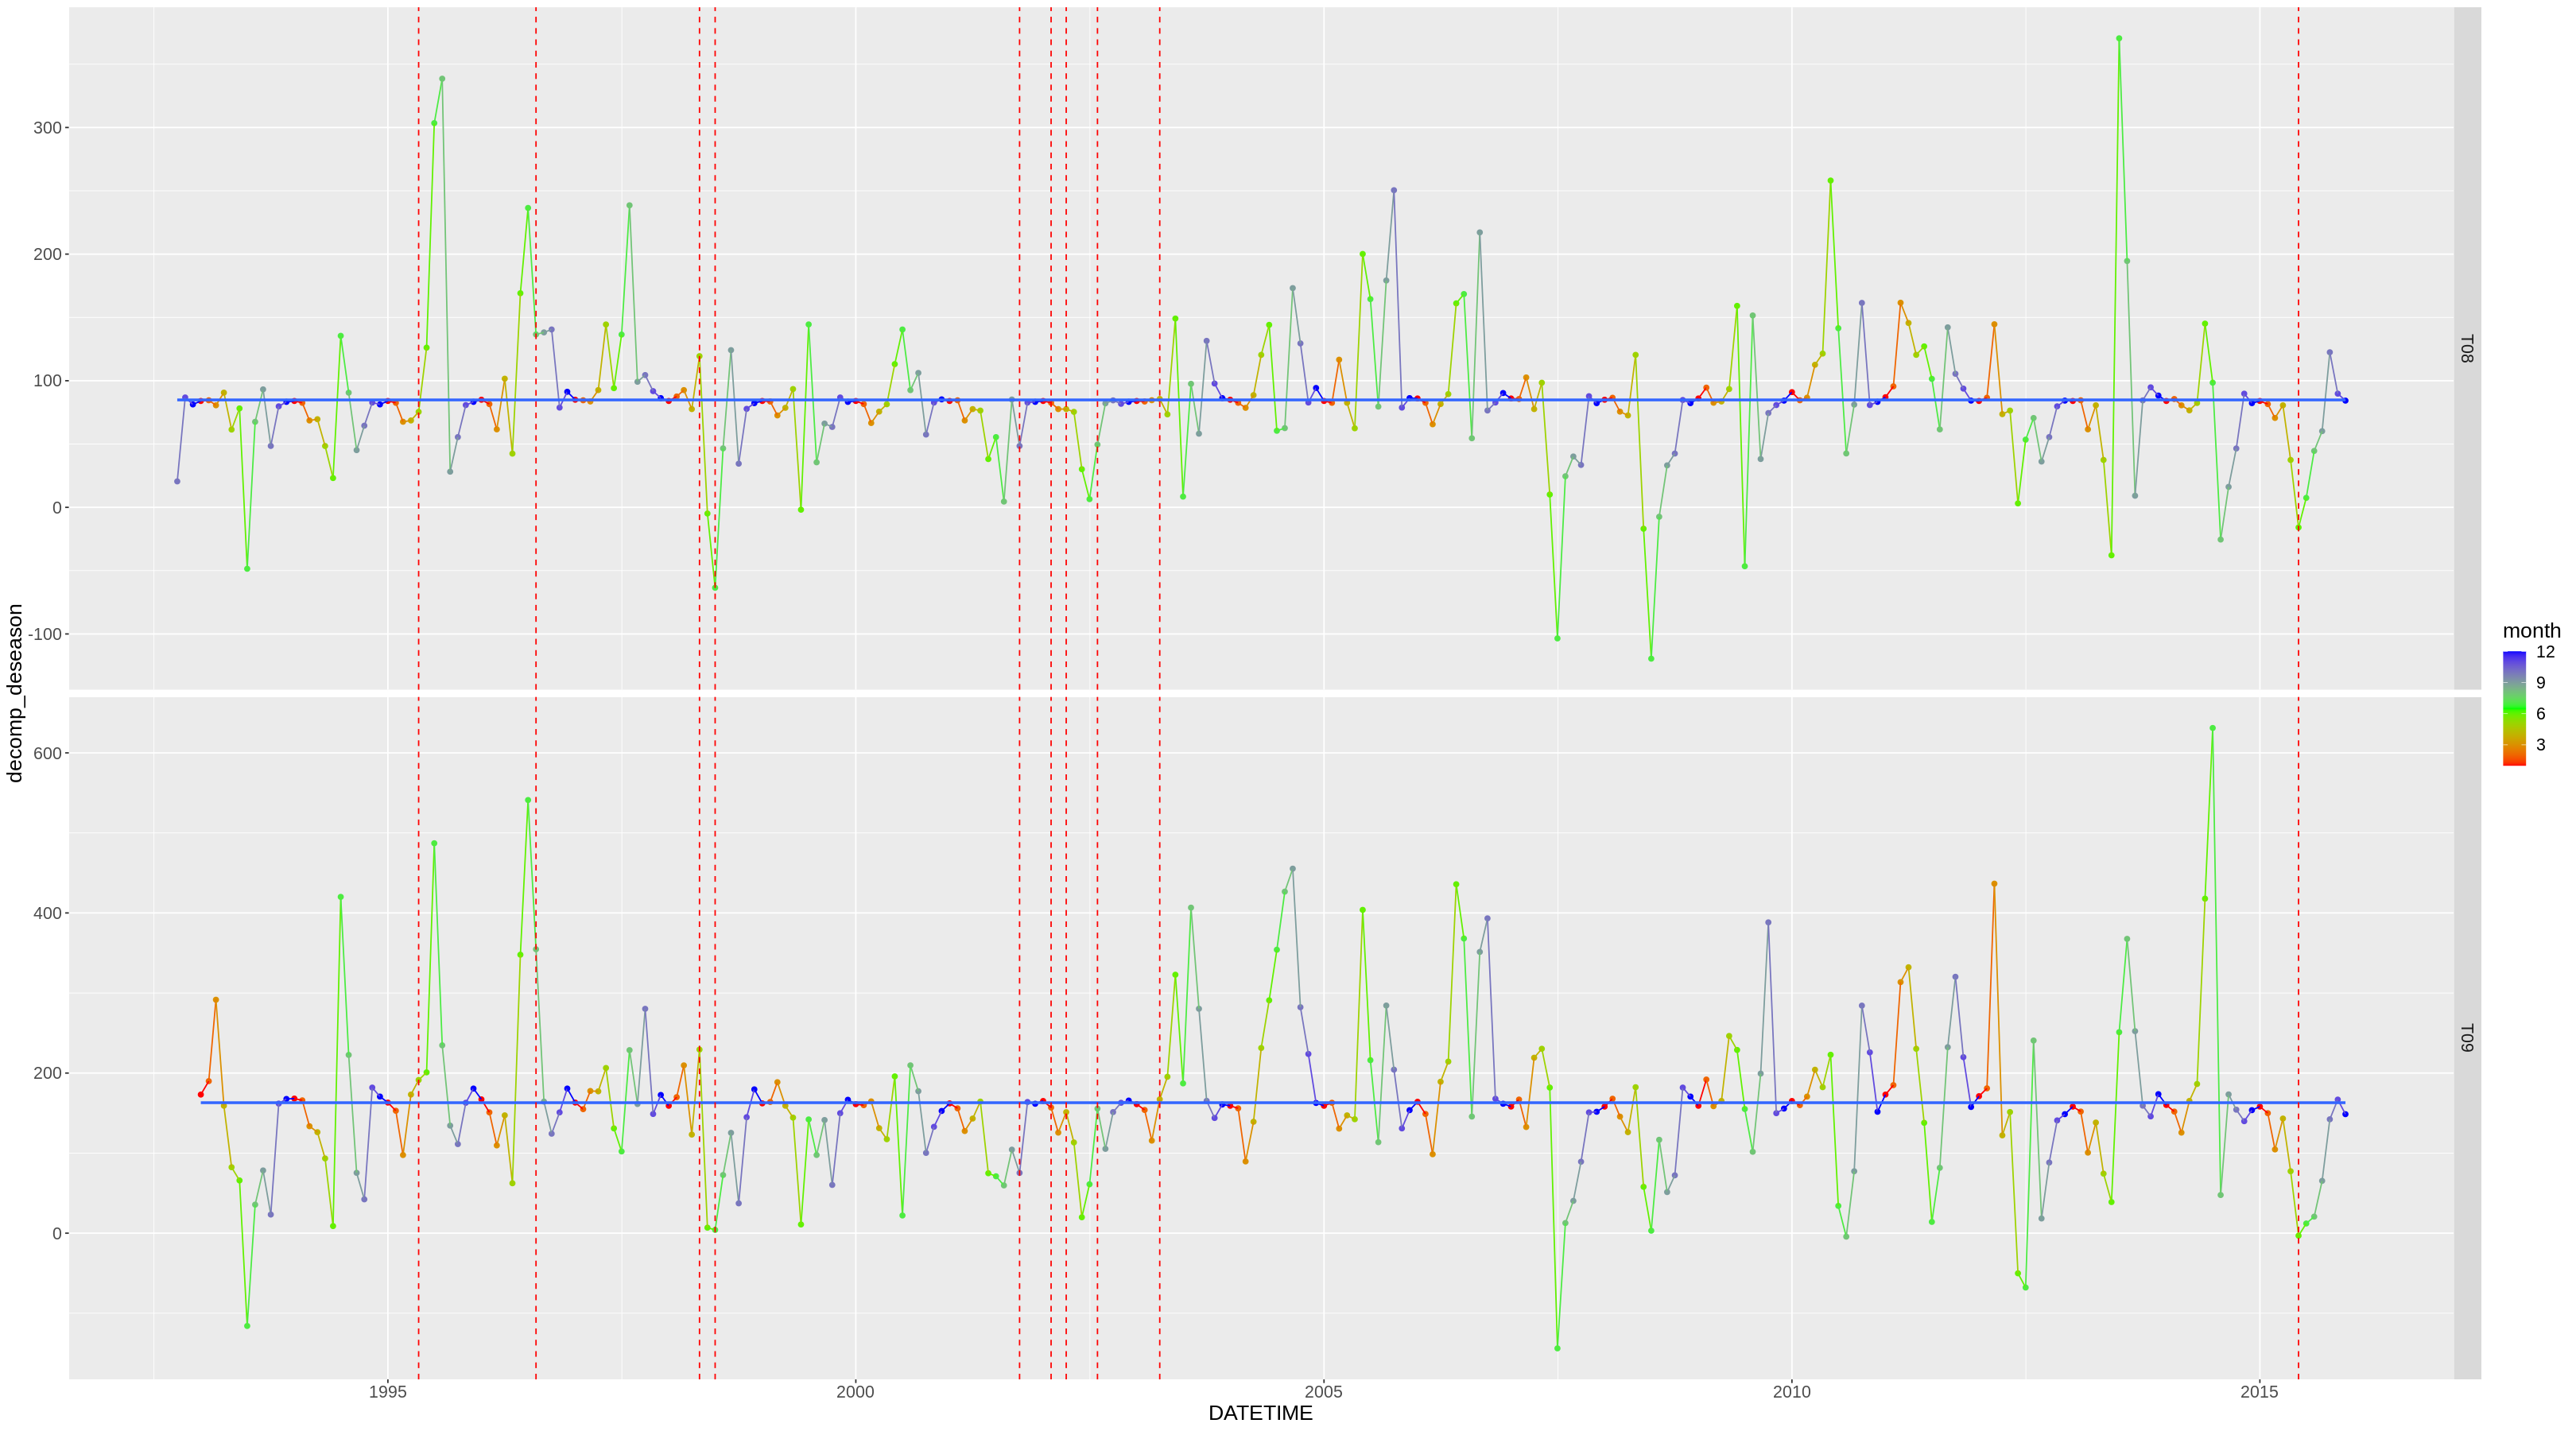

In [9]:
multifreq_cpts_dd <- multi_site_changepoints(
    data, 
    as.list(rep("bic",nsites)), 
    as.list(rep("normal_meanvar",nsites)), 
    "decomp_deseason")

deseasonalised_counts + 
    geom_vline(data = multifreq_cpts_dd, aes(xintercept = loc), color='red', linetype='dashed')

# Compare multi-frequency changepoints to univariate changepoints

Parsed with column specification:
cols(
  IM_SPEC = col_double(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)

Parsed with column specification:
cols(
  IM_SPEC = col_character(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)

Joining, by = c("site", "cpt.type", "loc")



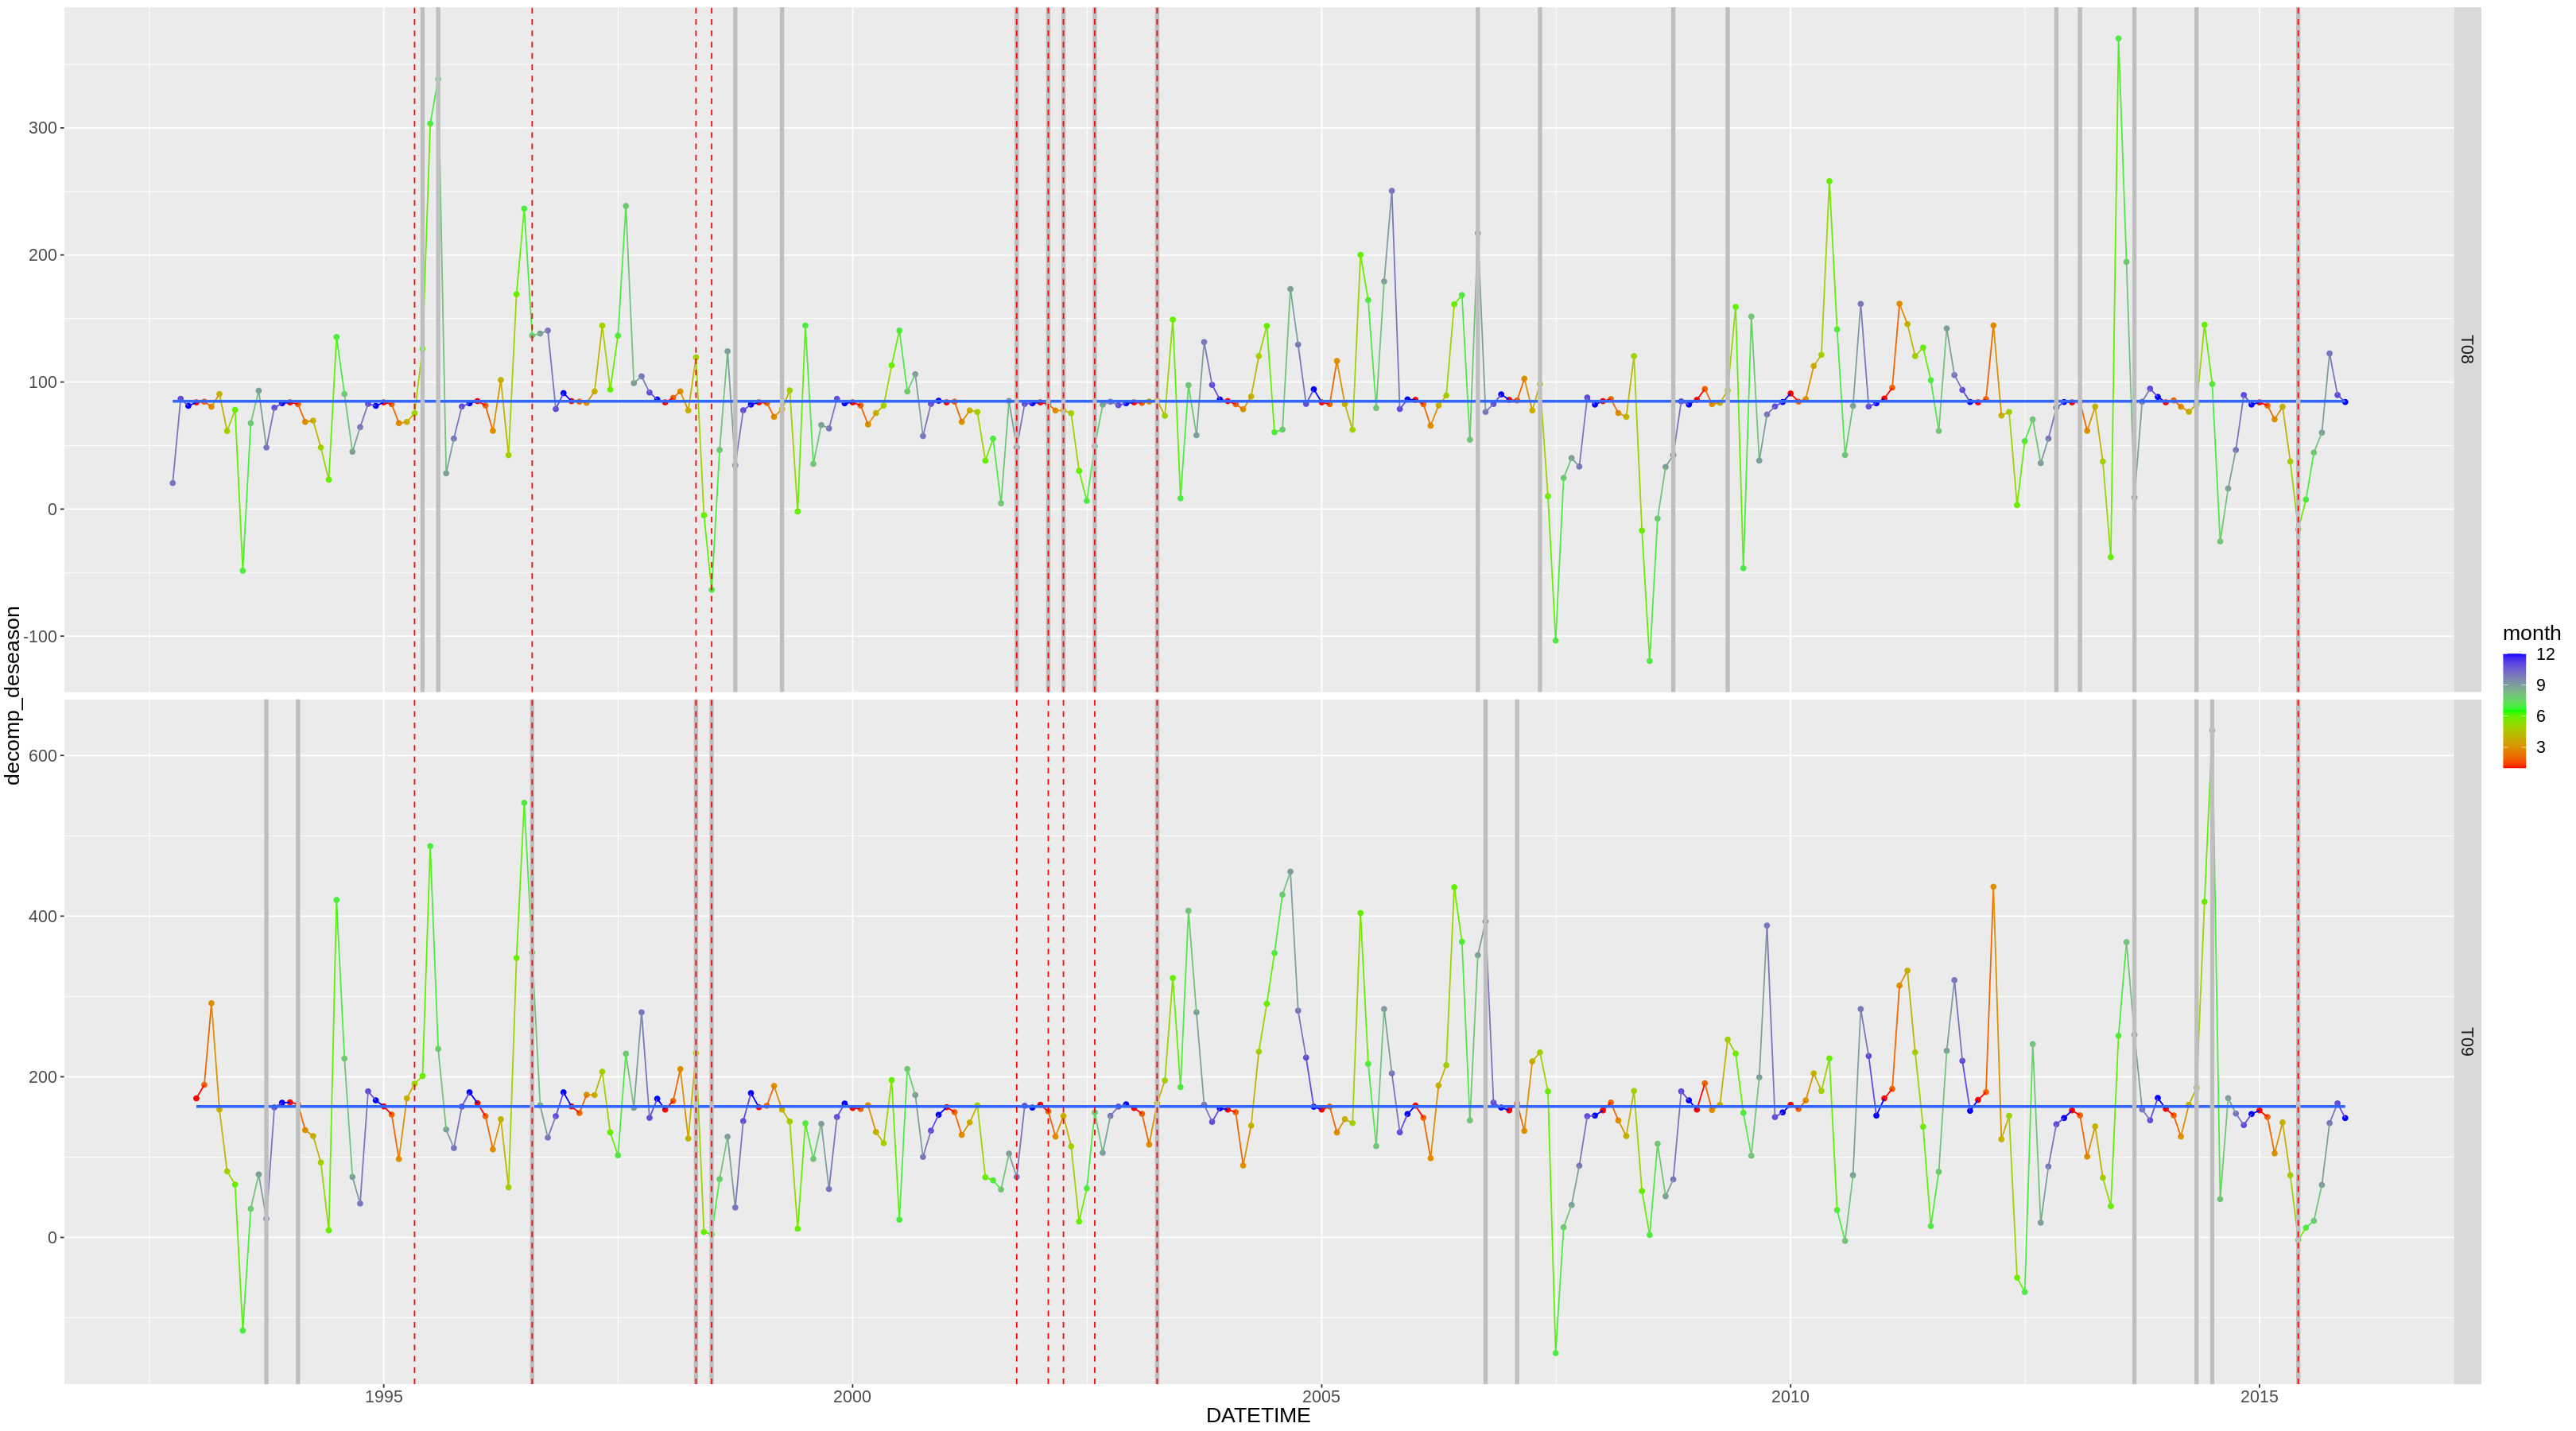

In [10]:
setwd("/data/notebooks/jupyterlab-workshop")
source("R/helper.R")

uni_cpts_dd <- multi_site_uni_changepoints(
    data, 
    as.list(rep("bic",nsites)), 
    as.list(rep("normal_meanvar",nsites)), 
    "decomp_deseason"
)

deseasonalised_counts + 
    geom_vline(data = uni_cpts_dd, aes(xintercept = loc), size=1.5, color='grey') +
    geom_vline(data = multifreq_cpts_dd, aes(xintercept = loc), color='red', linetype='dashed')

# Deseasonalised standardised values

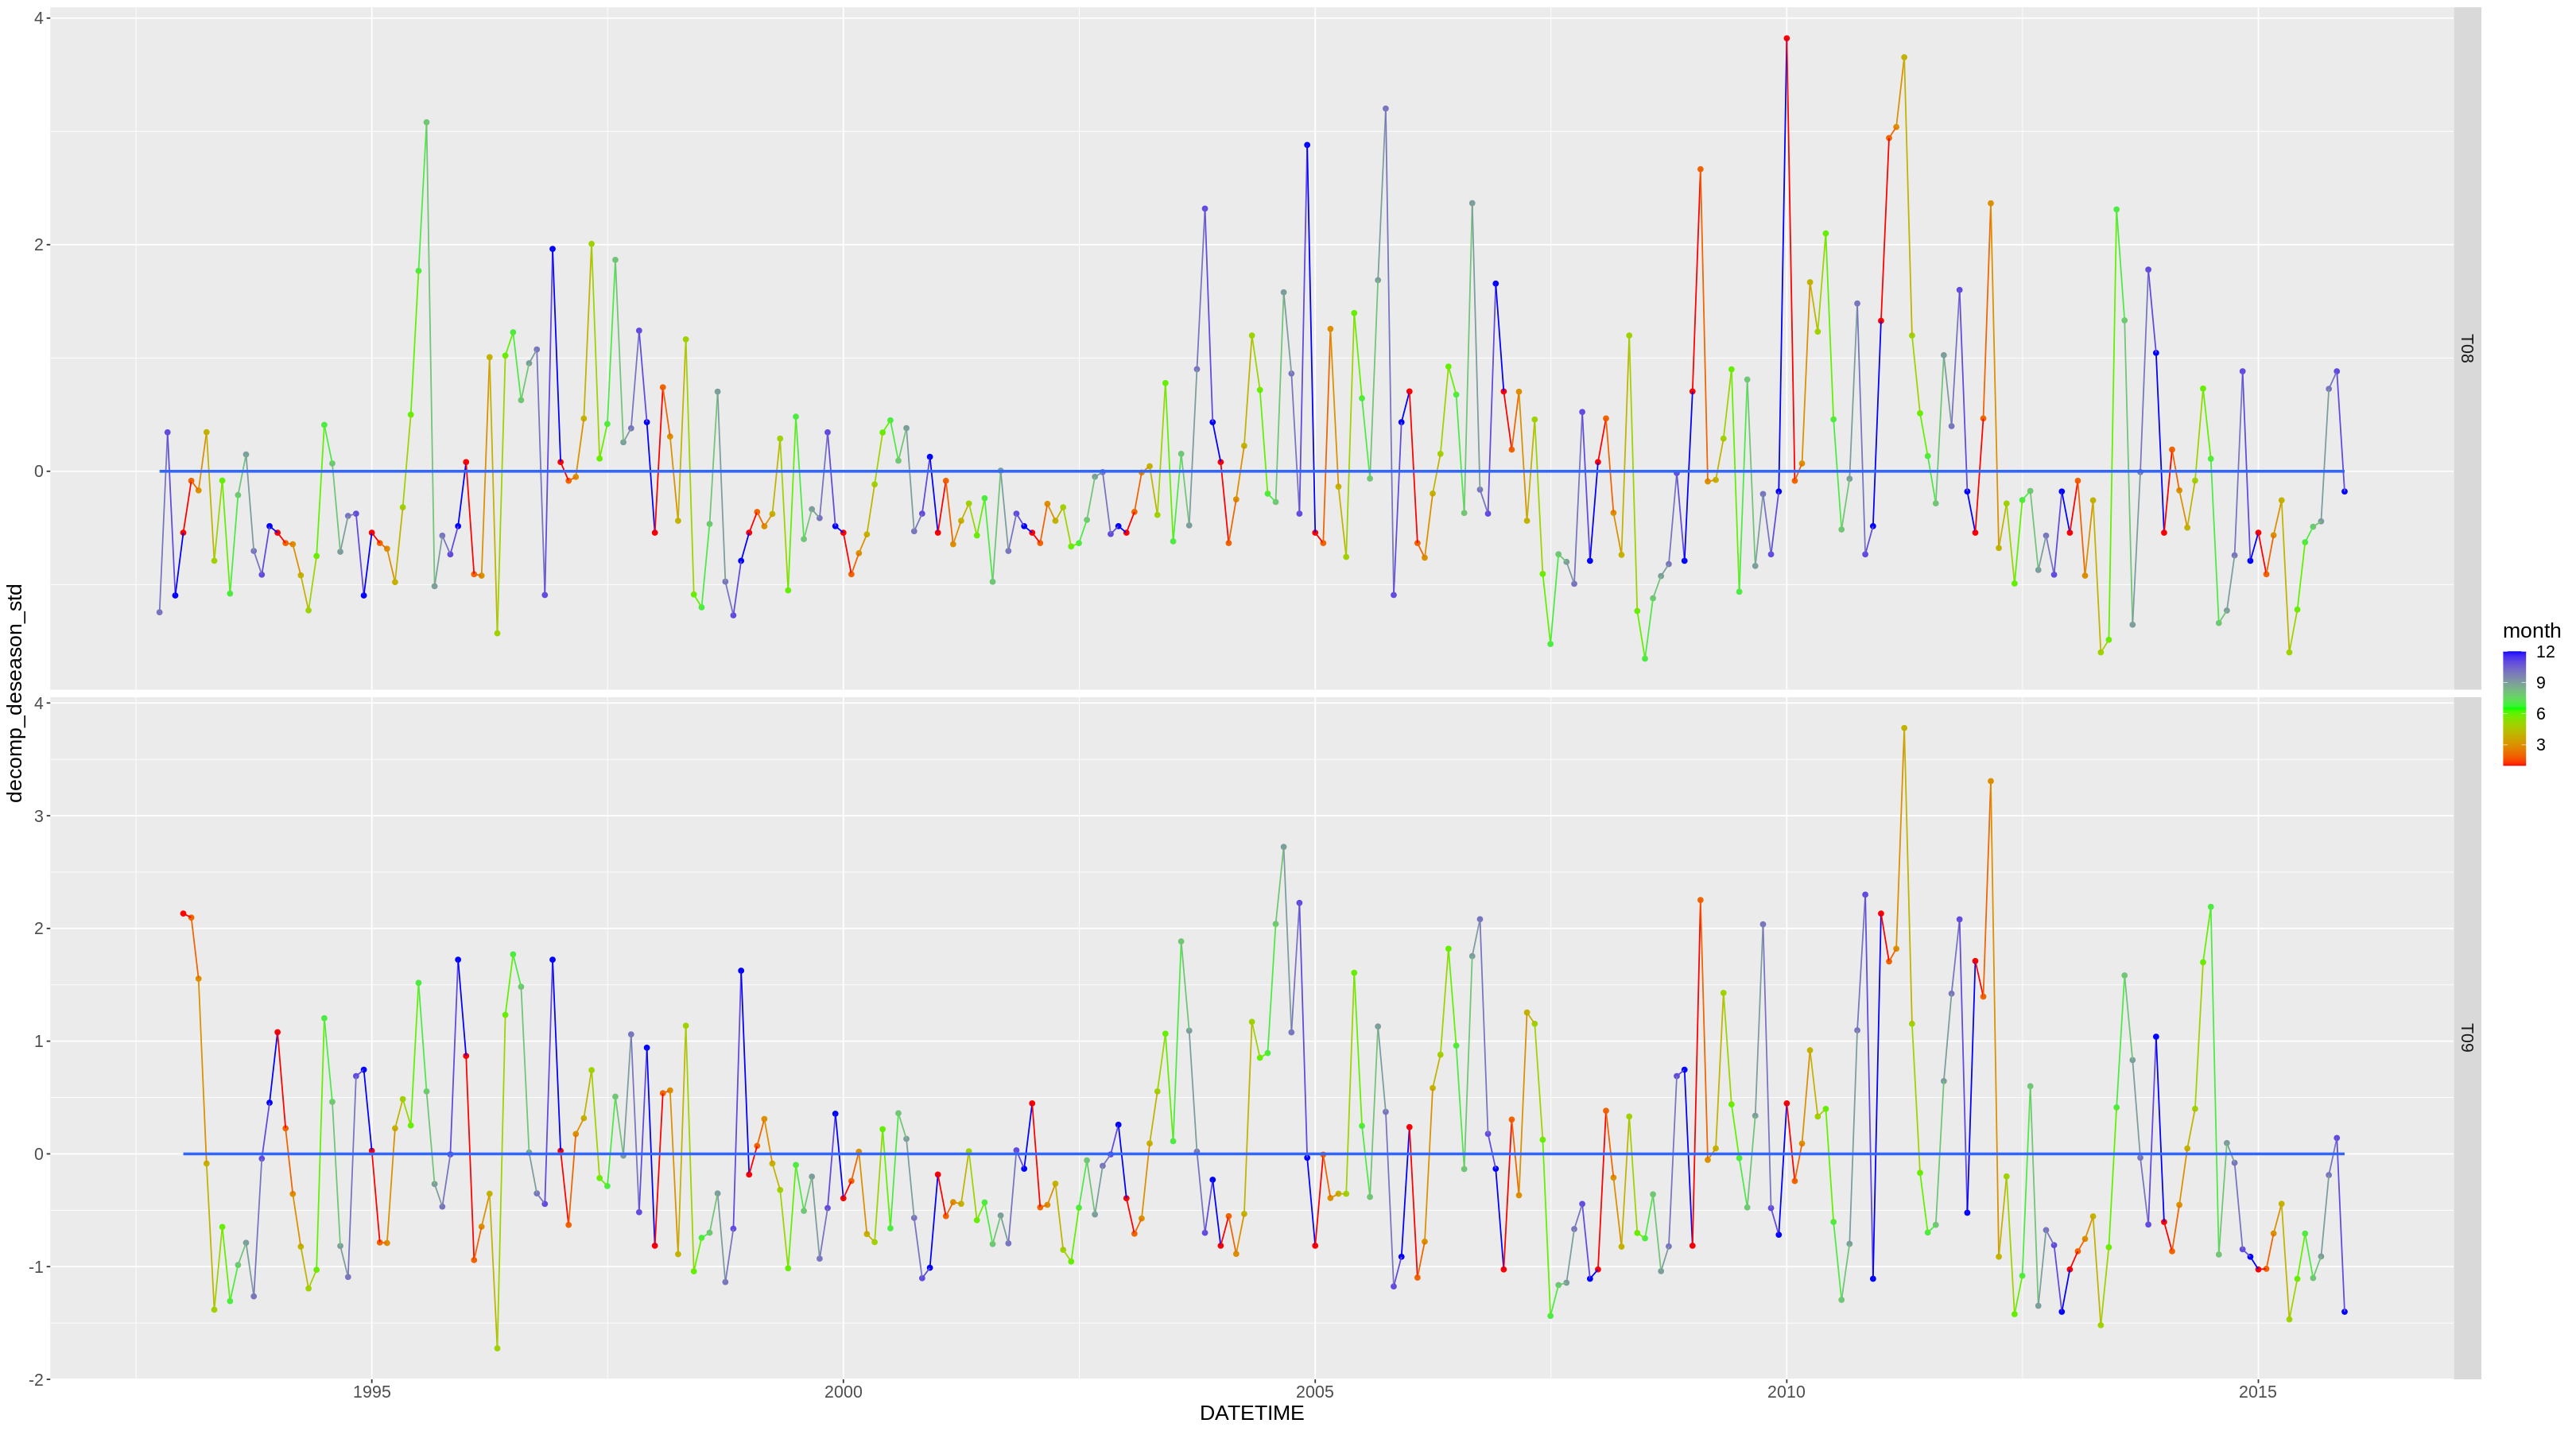

In [11]:
plot_decomp_deseason_std <- data %>% 
    ggplot2::ggplot(aes(x = DATETIME, y = decomp_deseason_std, color=month)) + 
    geom_point() +
    geom_line() + 
    scale_color_gradientn(colours = rainbow(3)) +
    stat_smooth(method='lm', formula=y~1, se=F) +
    facet_grid(site ~ ., scales='free_y') + 
    theme(text = element_text(size = 16))

print(plot_decomp_deseason_std)

# Deseasonalised standardised with multi frequency changepoints

Joining, by = c("site", "cpt.type", "loc")



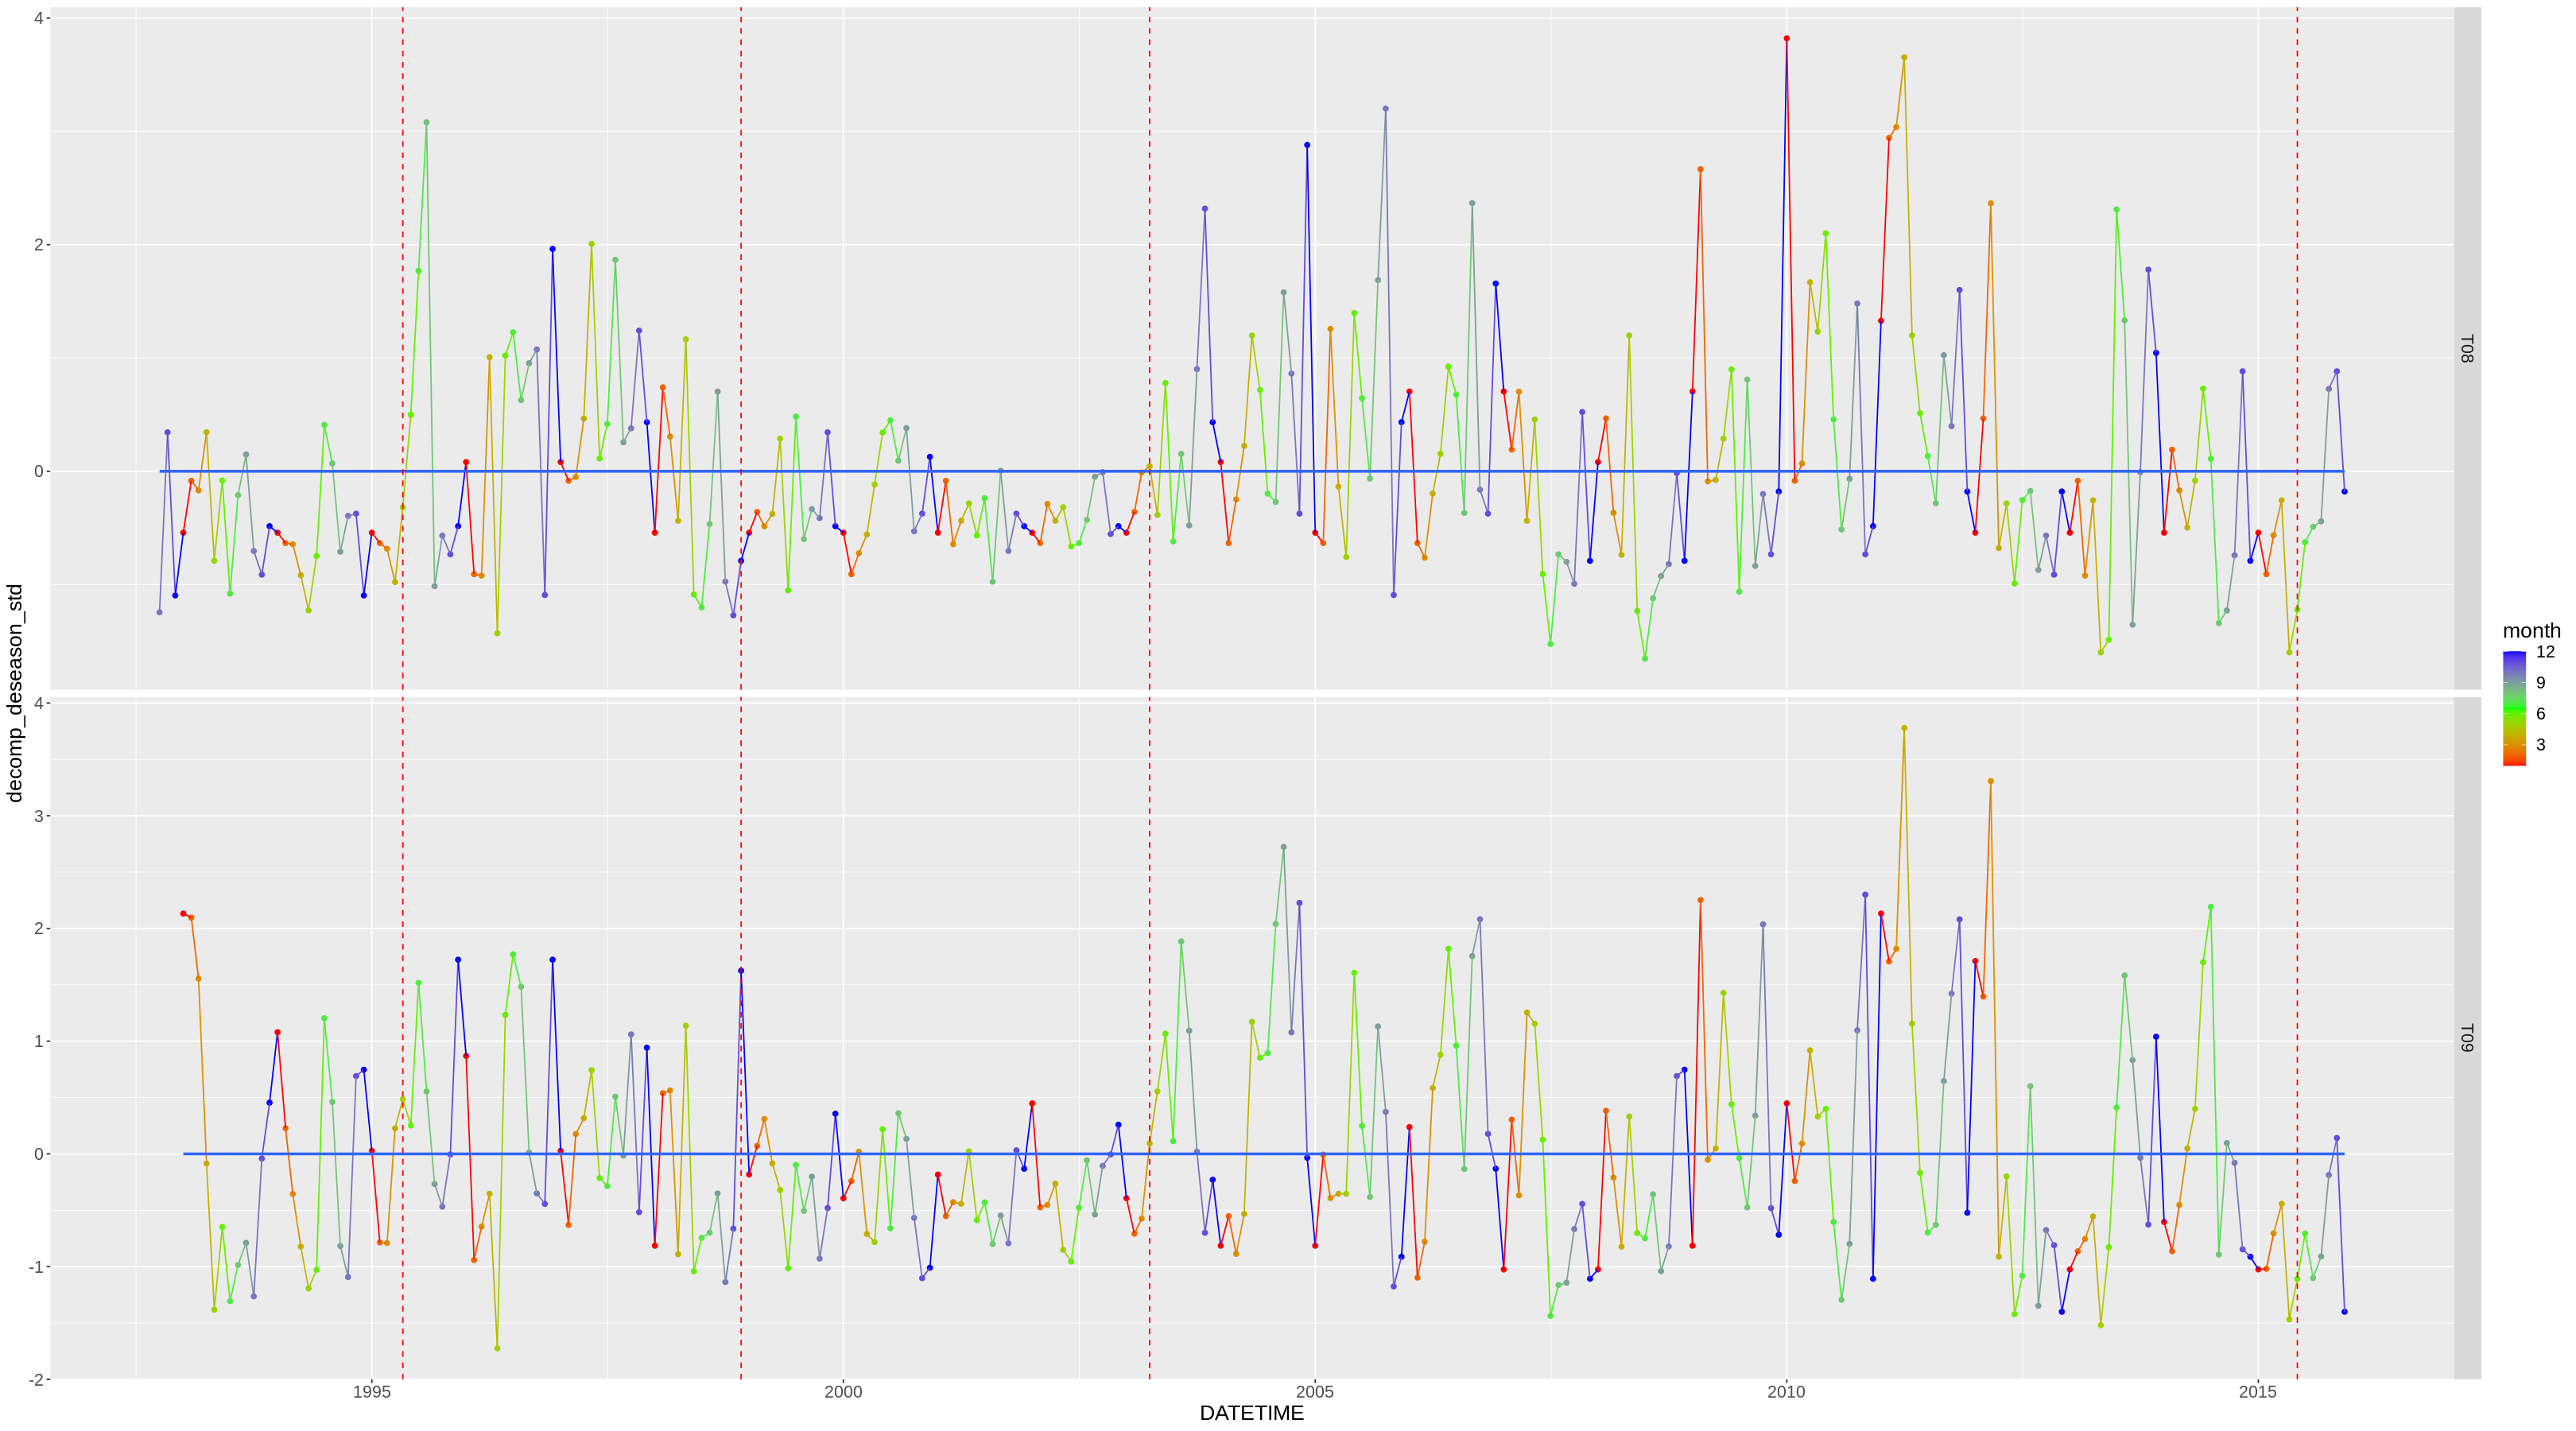

In [12]:
multifreq_cpts_ddstd <- multi_site_changepoints(
    data, 
    as.list(rep("bic",nsites)), 
    as.list(rep("normal_meanvar",nsites)), 
    "decomp_deseason_std")

plot_decomp_deseason_std + 
    geom_vline(data = multifreq_cpts_ddstd, aes(xintercept = loc), color='red', linetype='dashed')

# Deseasonalised standardised with multi frequency and univariate changepoints

Joining, by = c("site", "cpt.type", "loc")



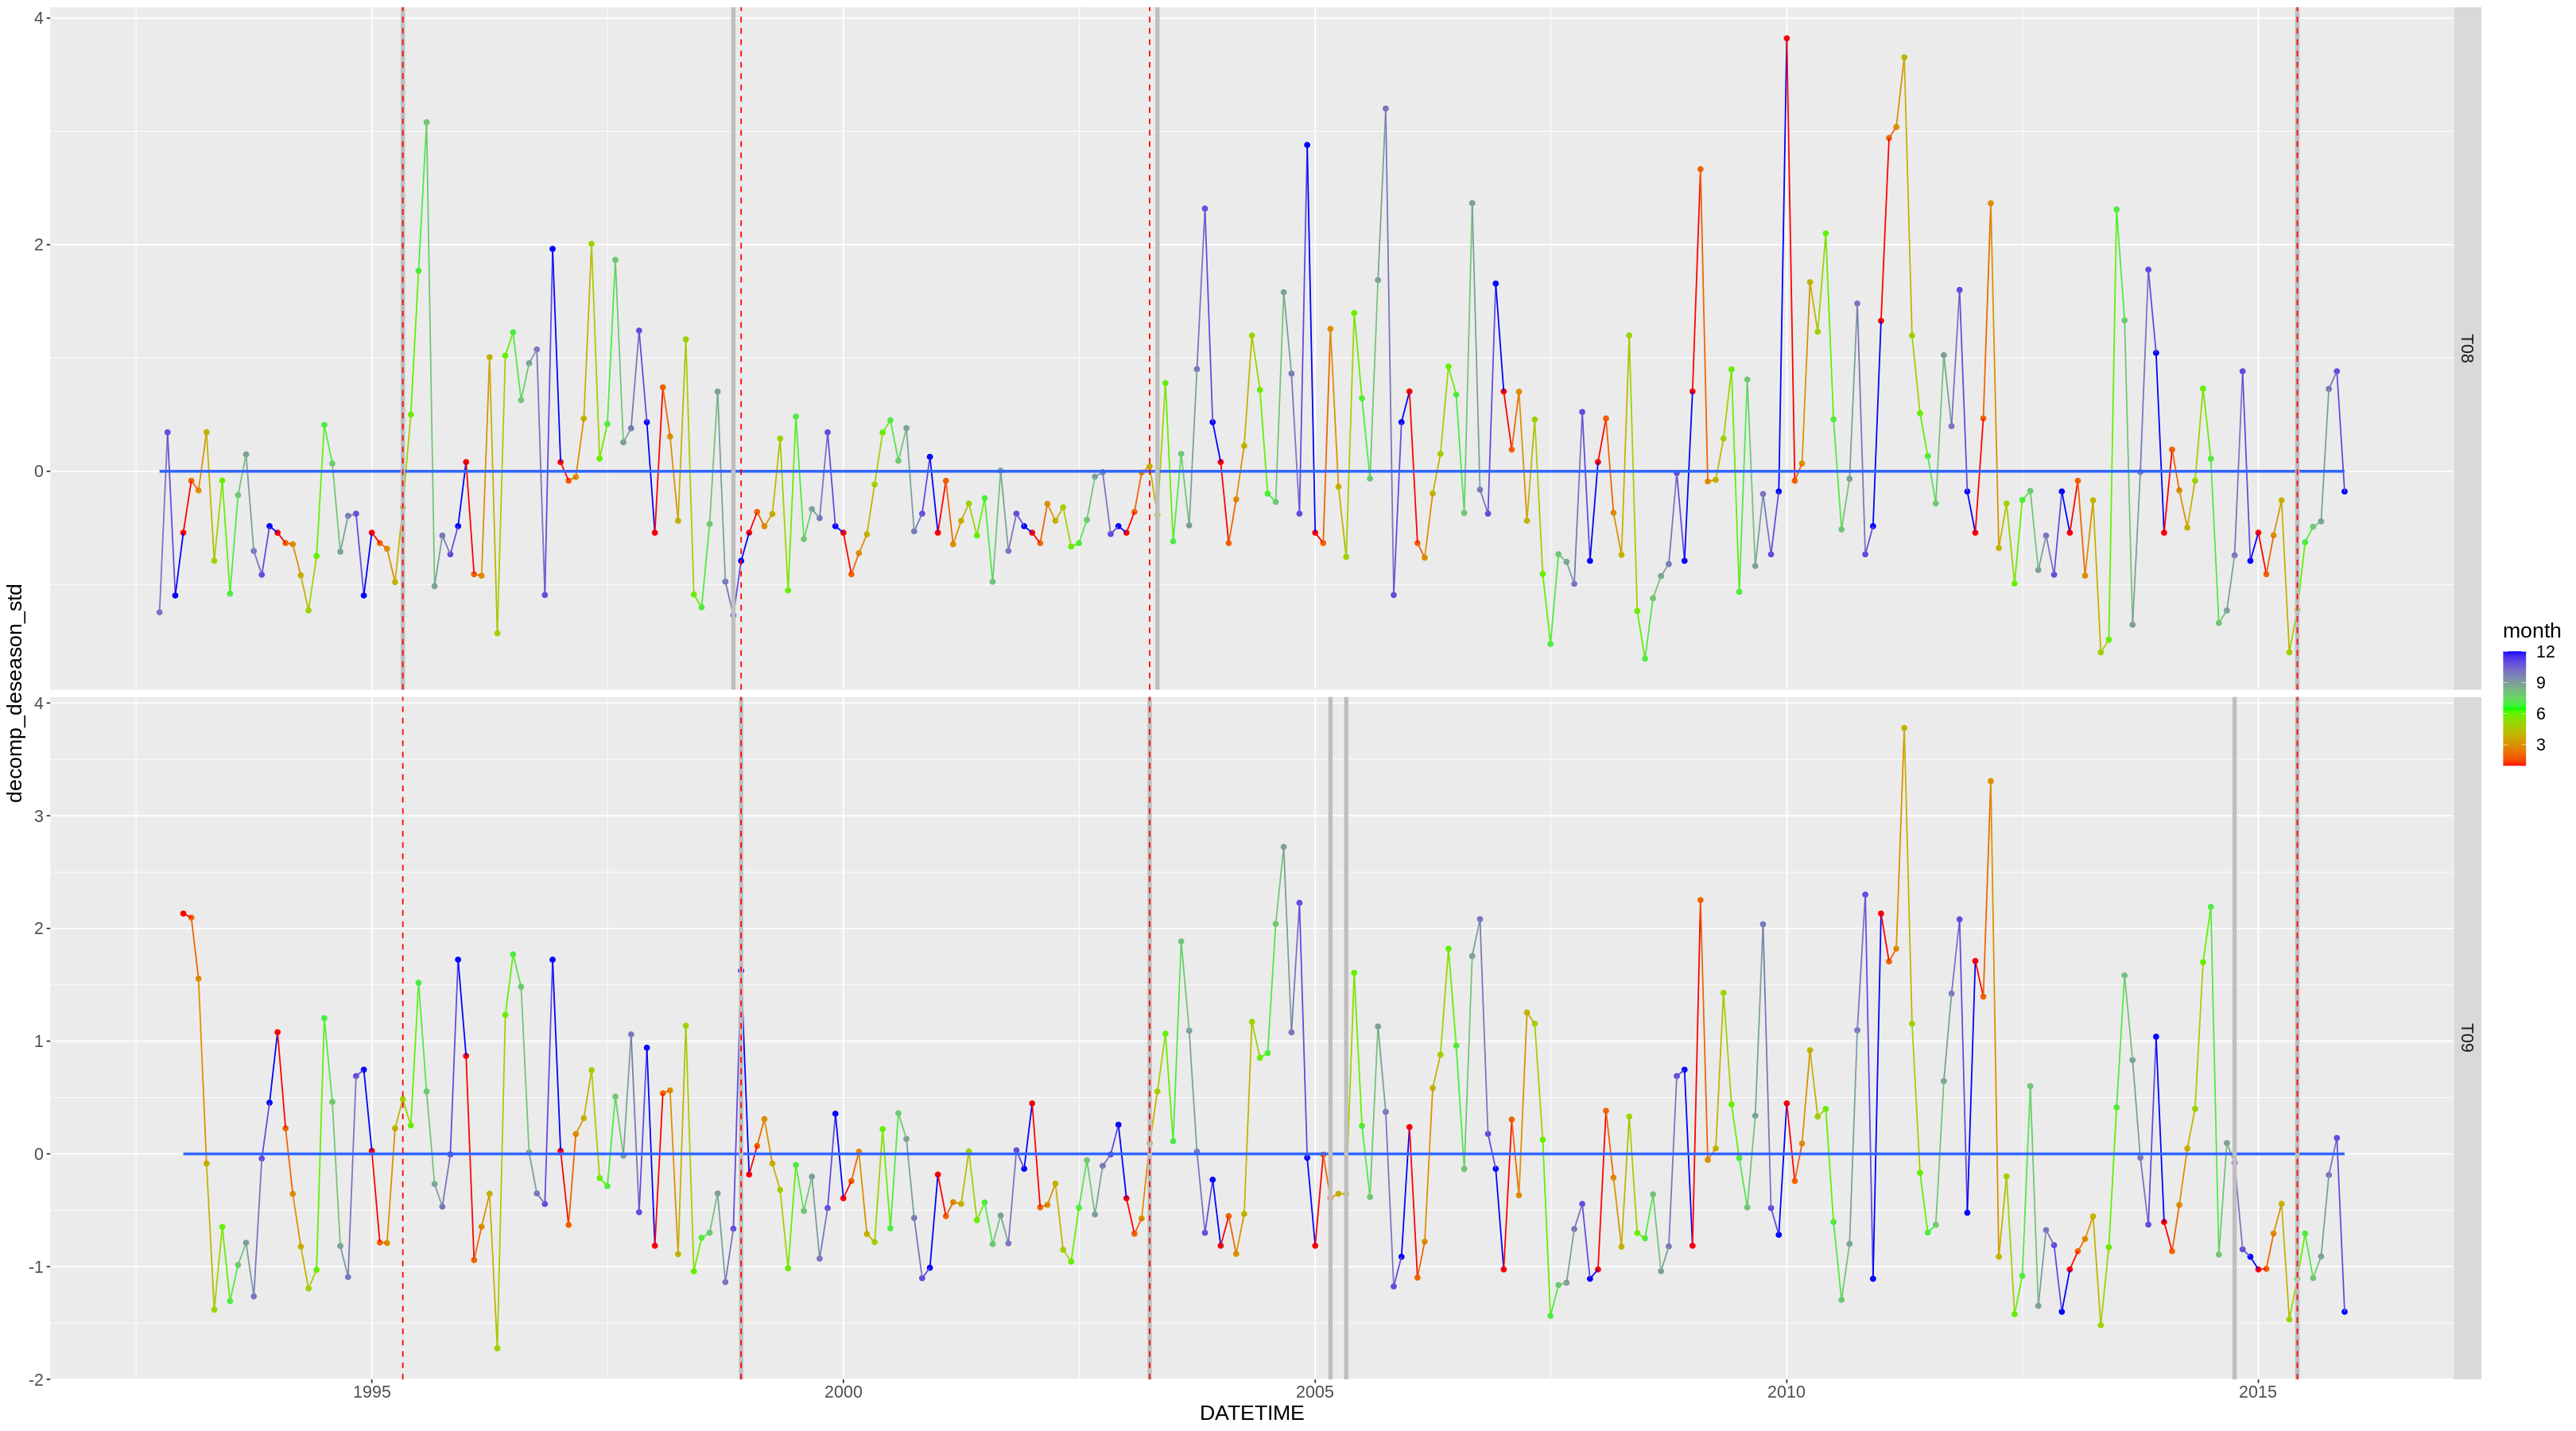

In [13]:
uni_cpts_ddstd <- multi_site_uni_changepoints(
    data, 
    as.list(rep("bic",nsites)), 
    as.list(rep("normal_meanvar",nsites)), 
    "decomp_deseason_std"
)

plot_decomp_deseason_std + 
    geom_vline(data = uni_cpts_ddstd, aes(xintercept = loc), size=1.5, color='grey') +
    geom_vline(data = multifreq_cpts_ddstd, aes(xintercept = loc), color='red', linetype='dashed')

What does this tell us?
1. Anything deviating from the blue horizontal line, either below or above "average".
2. Biggest changes are in the summer months (colours close to green) when moth counts are highest
3. Around 1996, below average May followed by very high June, July and August

# Moving average
Plot the [2x12ma](https://otexts.com/fpp2/moving-averages.html) moving average

In [14]:
plot_ma <- ggplot2::ggplot(data, aes(x = DATETIME, y = ma2x12)) + 
    geom_point() +
    geom_line() + 
    stat_smooth(method='lm', formula=y~1, se=F) + 
    facet_grid(site ~ ., scales='free_y') + 
    theme(text = element_text(size = 16))

# Plot ma2x12 (trend) with multi-frequency changepoints

Parsed with column specification:
cols(
  IM_SPEC = col_double(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)

Parsed with column specification:
cols(
  IM_SPEC = col_character(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)

Joining, by = c("site", "cpt.type", "loc")

Warning message:
“Removed 24 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 24 rows containing missing values (geom_point).”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


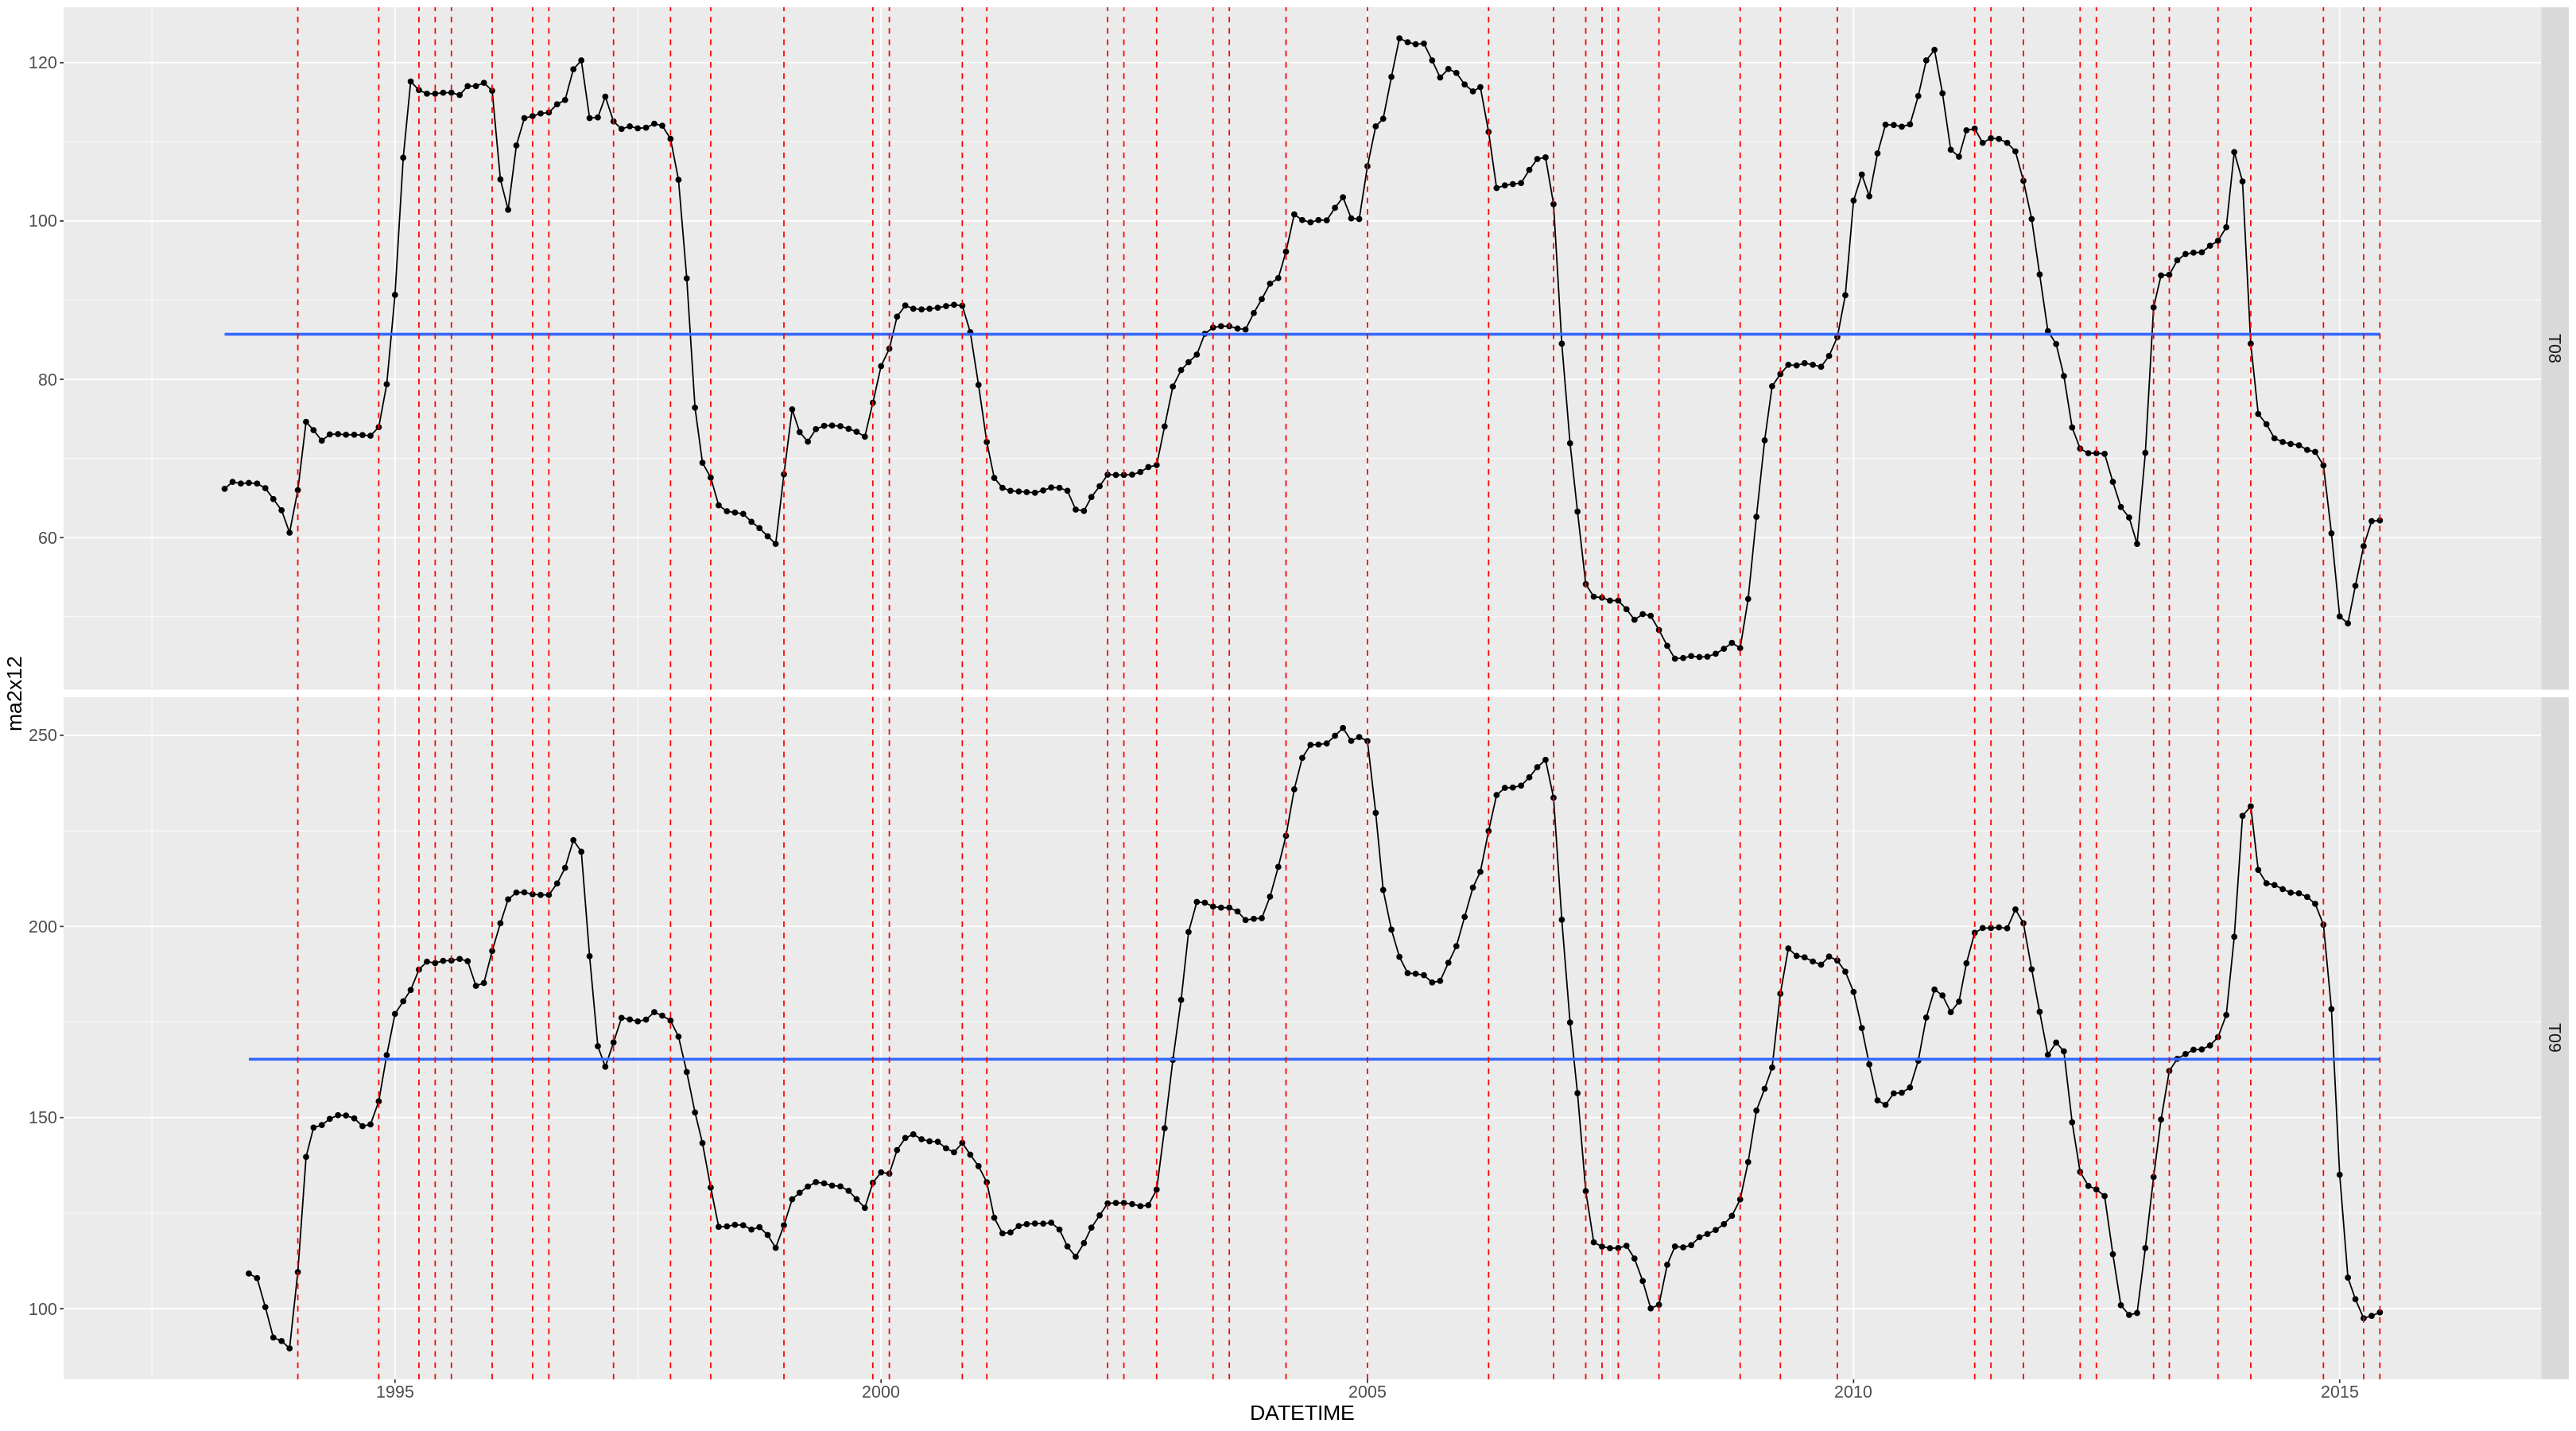

In [15]:
setwd("/data/notebooks/jupyterlab-workshop")
source("R/helper.R")

multifreq_cpts_ma2x12 <- multi_site_changepoints(
    data, 
    as.list(rep("bic",nsites)), 
    as.list(rep("normal_meanvar",nsites)), 
    "ma2x12")

plot_ma + 
    geom_vline(data = multifreq_cpts_ma2x12,
               aes(xintercept = loc), 
               color='red', 
               linetype='dashed')

# Plot ma2x12 (trend) with multi-frequency and univariate changepoints

Joining, by = c("site", "cpt.type", "loc")

Warning message:
“Removed 24 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 24 rows containing missing values (geom_point).”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


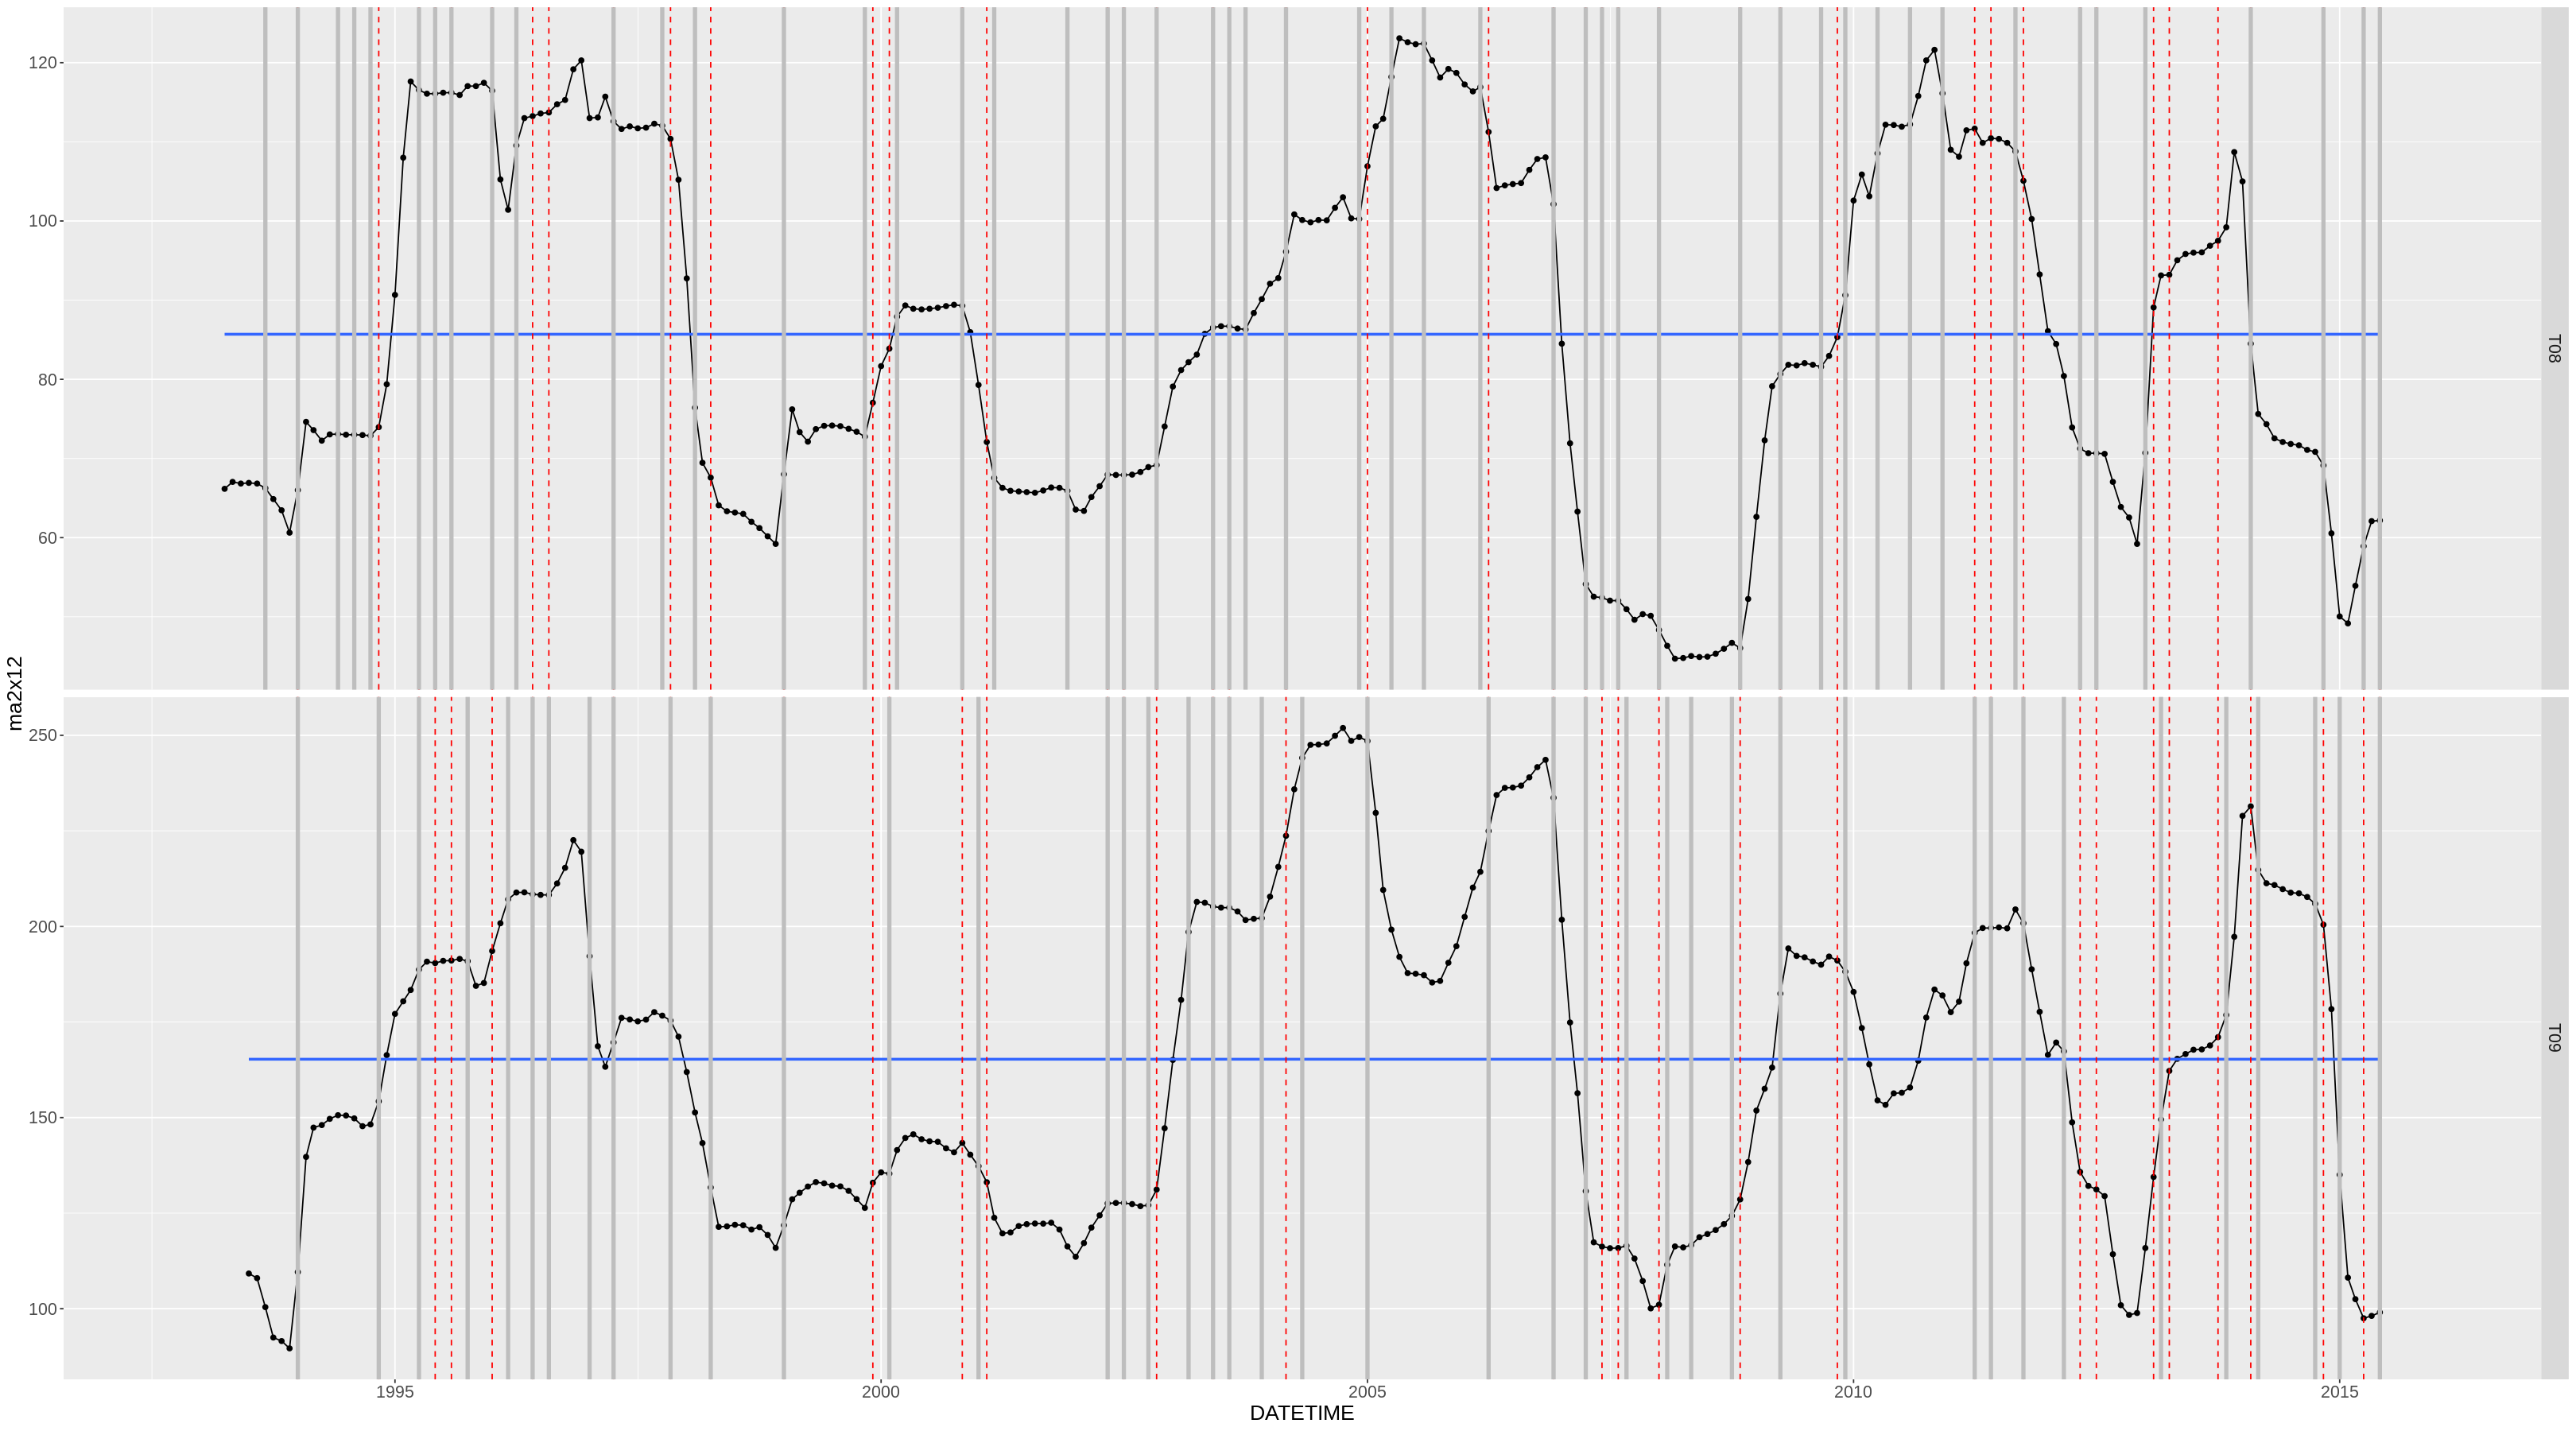

In [16]:
multifreq_cpts_uni_ma2x12 <- multi_site_uni_changepoints(
    data, 
    as.list(rep("bic",nsites)), 
    as.list(rep("normal_meanvar",nsites)), 
    "ma2x12")

plot_ma + 
    geom_vline(data = multifreq_cpts_ma2x12, aes(xintercept = loc), color='red', linetype='dashed') + 
    geom_vline(data = multifreq_cpts_uni_ma2x12, aes(xintercept = loc), size=1.5, color='grey')

